TODO:
- Implement what you've done but for scenario 2 (think its mostly just create a new q_table with the extra column for current queue)
- ~~Do FULL training run for Scenario 1, where you do 25000-30000 episodes with optimal epsilon. Take this model, and apply it to a random arrival rates to see how it does. If it does OK, then you can try against many random arrival rates.~~
- ~~Remove 'tuning arrival times' since I dont think you tune it, you're meant to test your model on different arrival times~~
- Look at learning rate/discount? Probs need to at least acknowledge it and try to do stuff with it

# Introduction
This introduction is just to give you the overall layout of the workbook so that you don't get confused on where to find what :)
The notebook has both Scenario 1 and Scenario 2.
It will go through everything in our approach to Q-Learning, from the initial model, 'tuning'/finding optimal parameters, and the final model.
Since Scenario 1 and 2 are vastly different, we will first walk through the approach for Scenario 1, and then the approach for Scenario 2.

In [1]:
# All Imports and Constants
import sys
!{sys.executable} -m pip install gym
import numpy as np
import gym
from gym import spaces
import copy
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.pyplot import figure
import random
from QueueSimulator import QueueSimulator
from QueueSimulatorScenario2 import QueueSimulatorScenario2

LEARNING_RATE = 0.1
DISCOUNT = 0.95
EPISODES = 5000 # Initial number for now, until tuning.
EPISODE_GRAPH_INTERVAL = EPISODES // 10

# parameters for epsilon decay policy
EPSILON = 1.0 # not a constant, going to be decayed
START_EPSILON_DECAYING = 1
END_EPSILON_DECAYING = EPISODES // 2
epsilon_decay_value = EPSILON / (END_EPSILON_DECAYING - START_EPSILON_DECAYING) # 1 / (2500 - 1) = 1 / 2499

# for testing
N_TEST_RUNS = 100
TEST_INTERVAL = 500

MAX_TIMESLOTS = 100
MAX_WAIT_STATE = 50 #used as upper limit in q-table

default_arrival_rates = [0.3, 0.25, 0.4]
MEAN_DELAY_REQUIREMENTS = [6, 4, np.inf]

# Scenario 1
# Pre-populating Queues
If given the arrival_rates and mean_delay_requirements, you could calculate what timeslots a packet will arrive for any number of timeslots. Hence, we believe that you should just 'pre-populate' your queues with the times that packets arrive at, since this simplifies all of the packet arrival/transmission, and you can later use this to measure wait times and give this information to your model to determine an action to take every step of the way.

In [2]:
# No need to put mean_delay_reqs as an arg since we won't be tuning this.
def prepopulate_queues(arrival_rates):
    arrival_rates = arrival_rates
    mean_delay_requirements = [6, 4, np.inf]
    # Keep track of current packets by using another array, which has index corresponding to the arrival_rates
    queues_packet_status = [0, 0, 0]
    # See all timeslots where a queue finished transmitting a packet
    queues_finished_timeslots = [[], [], []]

    # At each time interval, increment each queue's current packet status by the arrival rate amount
    # if packet status >= 1, get the extra amt above 1 and change packet status to just that
    for timeslot in range(1, MAX_TIMESLOTS+1):
        for current_queue in range (len(arrival_rates)):
            queues_packet_status[current_queue] += arrival_rates[current_queue]

            if queues_packet_status[current_queue] >= 1.0:
                queues_finished_timeslots[current_queue].append(timeslot)
                queues_packet_status[current_queue] -= 1.0
    print('Populated Queues with arrival rates: {0}. Packets per timeslot: {1}.'.format(arrival_rates, round(sum(arrival_rates),2)))
    return queues_finished_timeslots


'queues_finished_timeslots' is essentially our environment. We want to take this environment and apply it to a Q-Table, where the Q-Table represents all possible states (states being how long a queue has waited), then some reward for an action given a specific state. Below is what the Q-Table could look like, with a state e.g. (1, 0, 3) saying that the first packet in queue 1 has waited 1 timeslots, queue 2 has waited 0 timeslots, and queue 3 has waited 3 timeslots.

|                       | 0           | 1           | 2           |
|-----------------------|:-----------:|-------------|-------------|
| State (0, 0, 0)       | some-reward | some-reward | some-reward |
| State (0, 0, 1)       | some-reward | some-reward | some-reward |
| State (0, 1, 1)       | "         " | "         " | "         " |
| State (  ...  )       |             |             |             |
| State (Inf, Inf, Inf) | some-reward | some-reward | some-reward |

# Setting Up Q-Learning
First, we need to make a Q-Table with empty values. Access to an entry is given with the state (x, y, z).
Also, the upper state cannot be infinity so we can choose an arbitrary value (but still one that is somewhat realistic).

In [3]:
# -1 can be state, which represents that queue does not have a packet yet.
def create_q_table():
    q_table = {}
    for q1 in range (-1, MAX_WAIT_STATE+1):
        for q2 in range (-1, MAX_WAIT_STATE+1):
            for q3 in range (-1, MAX_WAIT_STATE+1):
                q_table[q1, q2, q3] = np.zeros(3)
    return q_table

In [4]:
def max_limit_state(state):
    for i, wait_time in enumerate(state):
        if wait_time > MAX_WAIT_STATE:
            state[i] = MAX_WAIT_STATE
    # Note: Need to convert new_state to tuple since q_table entries are as tuples
    return tuple(state)

def q_learning_initial(env, q_table):
    for episode in range(1,EPISODES+1):
        done = False
        state = max_limit_state(env.reset(episode))
        steps = 0
        epsilon = EPSILON

        # Either do action from QTable or random action
        while not done:
            if np.random.random() < 1 - epsilon:
                action = np.argmax(q_table[state])
            else:
                action = env.action_space.sample()
                
            # Get the next state, reward, new done value, and info (not sure what this is)
            # Also, in early episodes the queues can wait for very long times. Put a limit on the wait times in new_state
            new_state, reward, done, info = env.step(action)
            new_state = max_limit_state(new_state)

            # Update QTable and calc reward. Not sure why current_q in example is 'discretState+(action,)'
            new_max_q = np.max(q_table[new_state])
            current_q = q_table[new_state][action]
            q_table[new_state][action] = (1 - LEARNING_RATE)*current_q + LEARNING_RATE*(reward + DISCOUNT*new_max_q)

            state = new_state
            steps += 1

        # Finished done loop, update epsilon
        if END_EPSILON_DECAYING >= episode and episode >= START_EPSILON_DECAYING:
            epsilon -= epsilon_decay_value
            
        # Print progress every X episodes
        if episode % TEST_INTERVAL == 0 and episode != 0:
            print('Finished {0} episodes'.format(episode))

    print('Finished all episodes')
    env.close()
    return q_table

# Graph Methods
To better visualise how well the model has done, we should graph the wait times for packets in the queues for a model.

In [5]:
# Generic method so that we can use it later for other tuned-algorithms
def graph_q_learning_wait_times(env):
    row = 0
    col = 0
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(24, 26))
    for episode in env.packets_total_wait_times_map:
        ax = axes[row][col]
        q1_ep_y = env.packets_total_wait_times_map.get(episode)[0]
        q2_ep_y = env.packets_total_wait_times_map.get(episode)[1]
        q3_ep_y = env.packets_total_wait_times_map.get(episode)[2]
        q1_ep_x = [*range(1, len(q1_ep_y)+1, 1)]
        q2_ep_x = [*range(1, len(q2_ep_y)+1, 1)]
        q3_ep_x = [*range(1, len(q3_ep_y)+1, 1)]

        ax.set_title('Episode {0} Wait Times for Scenario {1}'.format(episode, env.scenario))
        ax.set_xlabel('Packet Number')
        ax.set_ylabel('Wait Time (in timeslots)')
        ax.plot(q1_ep_x, q1_ep_y, label='Queue1')
        ax.plot(q2_ep_x, q2_ep_y, label='Queue2')
        ax.plot(q3_ep_x, q3_ep_y, label='BestEffortQueue')
        ax.legend()
        col += 1

        if col == 2:
            row += 1
            col = 0
    fig.tight_layout()
    plt.show()
    
# Another generic method to graph wait times but only for the last episode in the 'wait times map'
def graph_q_learning_wait_times_last_episode(env):
    last_episode = list(env.packets_total_wait_times_map.keys())[-1]
    q1_y = env.packets_total_wait_times_map.get(last_episode)[0]
    q2_y = env.packets_total_wait_times_map.get(last_episode)[1]
    q3_y = env.packets_total_wait_times_map.get(last_episode)[2]
    q1_x = [*range(1, len(q1_y)+1, 1)]
    q2_x = [*range(1, len(q2_y)+1, 1)]
    q3_x = [*range(1, len(q3_y)+1, 1)]
    
    plt.figure()
    plt.plot(q1_x, q1_y, label='Queue1')
    plt.plot(q2_x, q2_y, label='Queue2')
    plt.plot(q3_x, q3_y, label='BestEffortQueue')
    plt.title('Episode {0} Wait Times for Scenario {1}'.format(last_episode, env.scenario))
    plt.xlabel('Packet Number')
    plt.ylabel('Wait Time (in timeslots)')
    plt.legend()
    plt.show()

# Method to graph the results from the final model on an arrival rate set
def graph_model_vs_arrival_rates(env):
    q1_y = env.packets_total_wait_times[0]
    q2_y = env.packets_total_wait_times[1]
    q3_y = env.packets_total_wait_times[2]
    q1_x = [*range(1, len(q1_y)+1, 1)]
    q2_x = [*range(1, len(q2_y)+1, 1)]
    q3_x = [*range(1, len(q3_y)+1, 1)]

    plt.figure()
    plt.plot(q1_x, q1_y, label='Queue1')
    plt.plot(q2_x, q2_y, label='Queue2')
    plt.plot(q3_x, q3_y, label='BestEffortQueue')
    plt.title('Performance with Arrival Rates: {0}'.format(env.arrival_rates))
    plt.xlabel('Packet Number')
    plt.ylabel('Wait Time (in timeslots)')
    plt.legend()
    plt.show()

Populated Queues with arrival rates: [0.3, 0.25, 0.4]. Packets per timeslot: 0.95.
Finished 500 episodes
Finished 1000 episodes
Finished 1500 episodes
Finished 2000 episodes
Finished 2500 episodes
Finished 3000 episodes
Finished 3500 episodes
Finished 4000 episodes
Finished 4500 episodes
Finished 5000 episodes
Finished all episodes
Average Wait Time in last episode: [2.86, 2.28, 24.73]


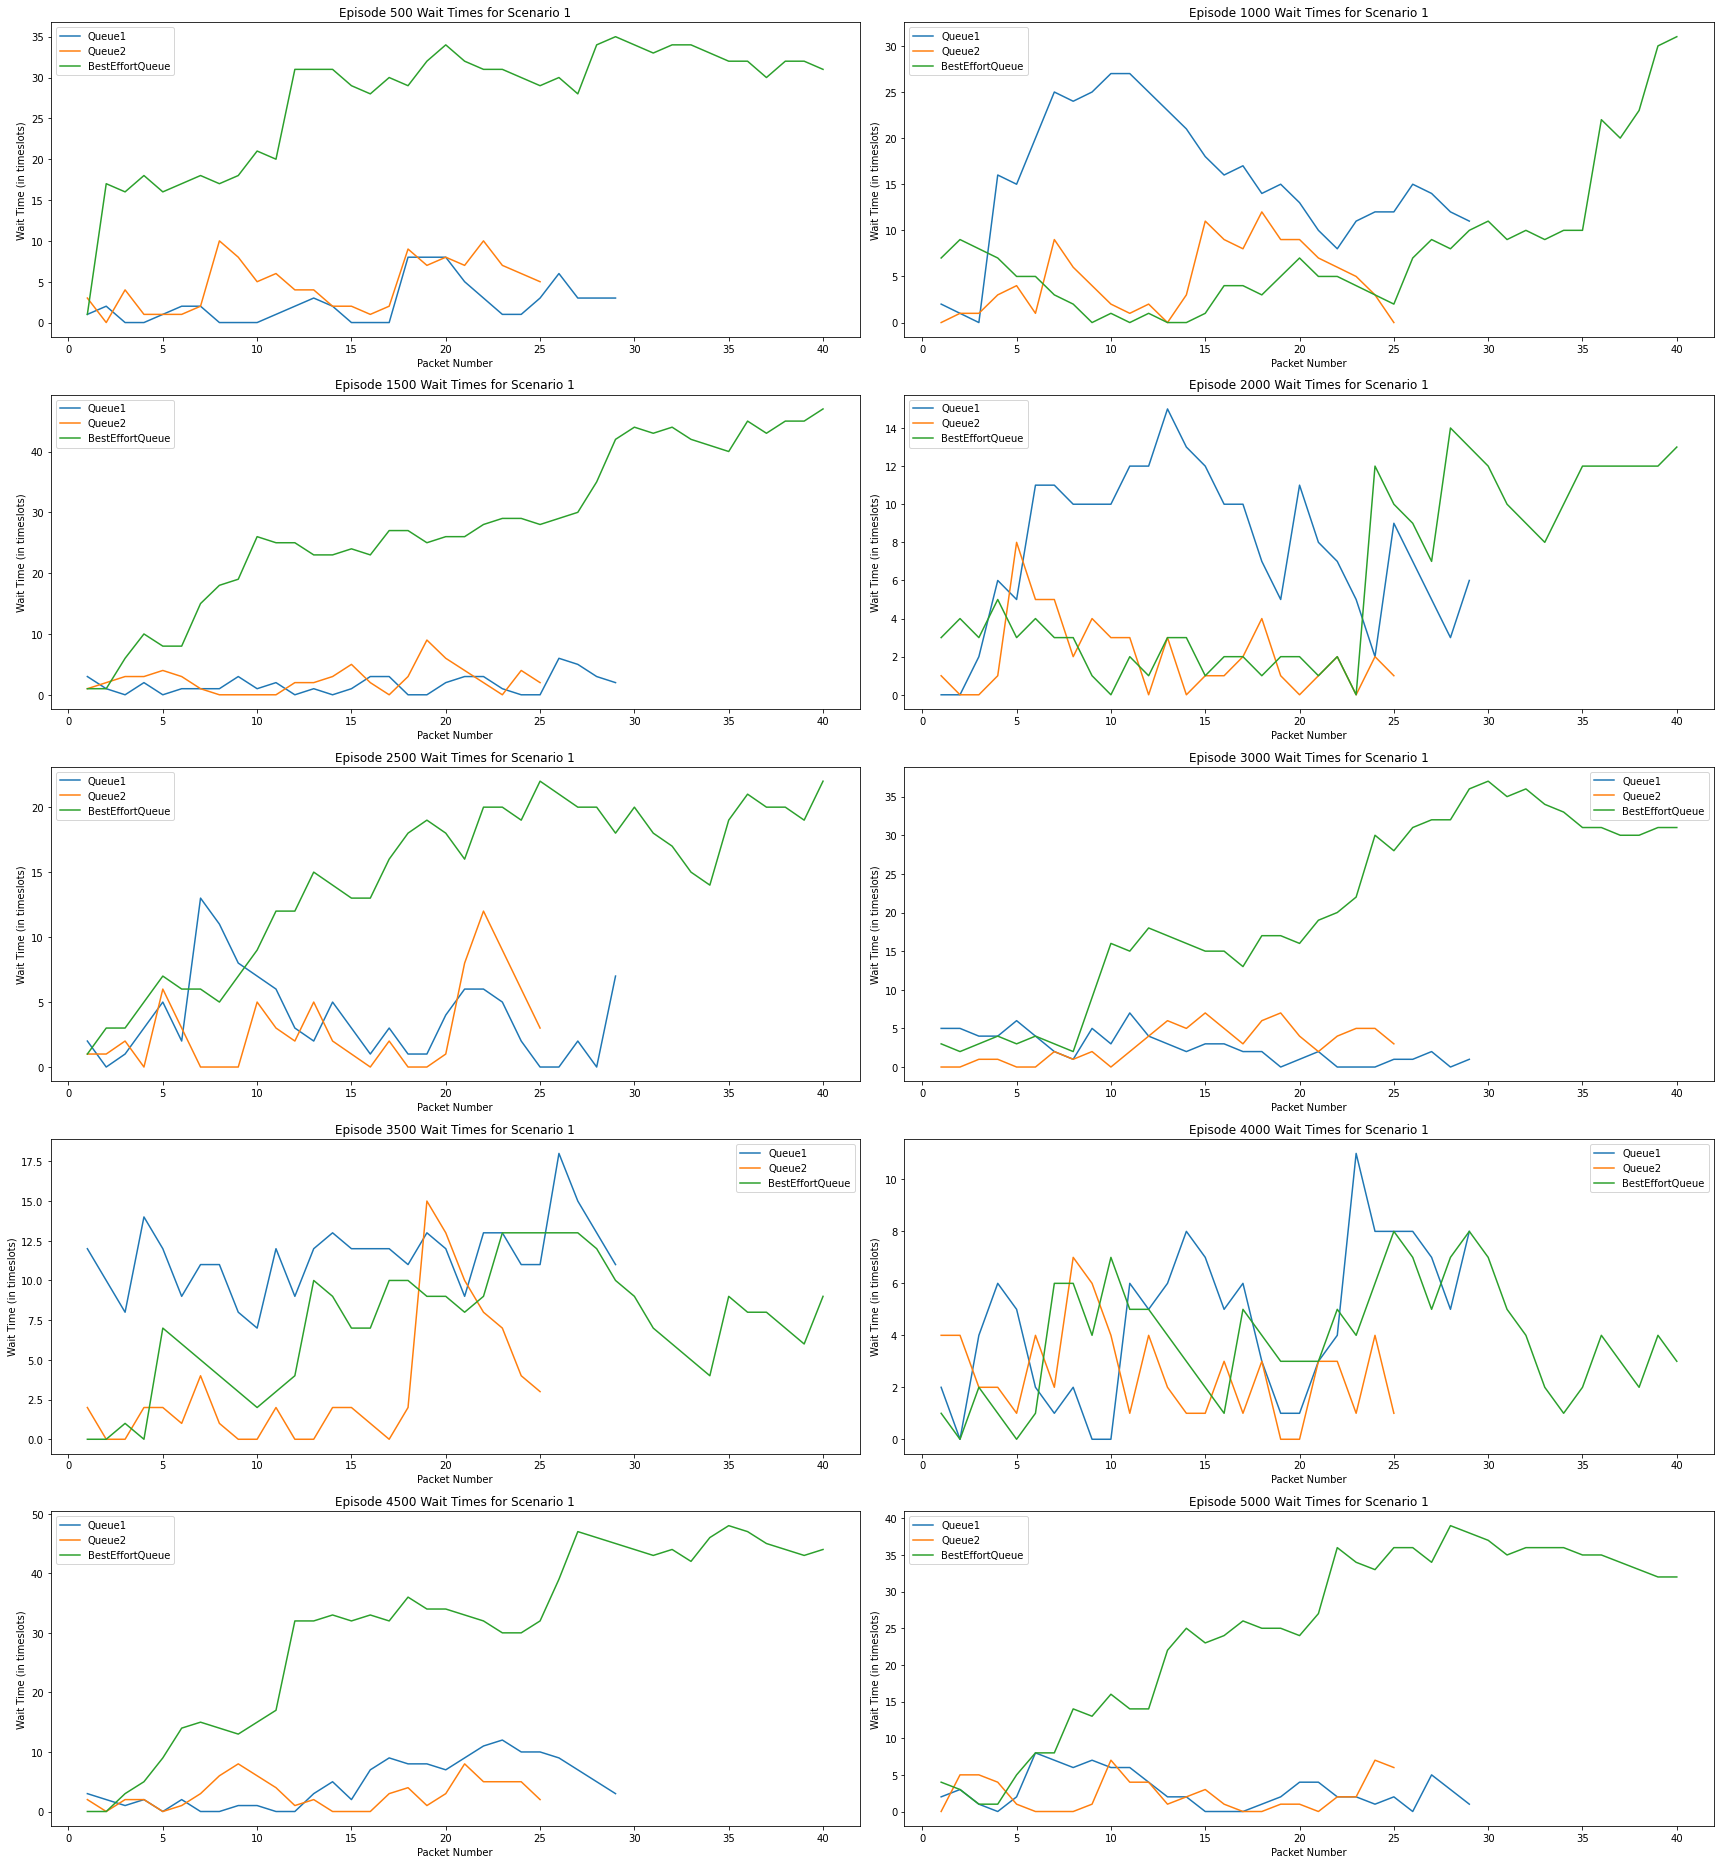

In [6]:
populated_queues = prepopulate_queues(default_arrival_rates)

env = QueueSimulator(default_arrival_rates, MEAN_DELAY_REQUIREMENTS, populated_queues)
q_table = create_q_table()
result_q_table = q_learning_initial(env, q_table)
print('Average Wait Time in last episode: {0}'.format(env.calc_average_wait_time()))
graph_q_learning_wait_times(env)

# Results of Initial Model
The initial models have varying performance between episodes. There are many places we can look to tune our methodology to improve our algorithm. Such places are the number of episodes, number of packets (i.e. arrival rates), and epsilon decay formula.

# Tuning
## Tuning 1.1: Episodes
We hypothesise that using the results so far, can conclude that increasing the number of episodes gets the model to experience more overall, and since randomness has a 'butterfly' effect in our situation, an episode can differ greatly from another. The question is at what point do the number of episodes does not matter? To explore this, we can try creating an environment and running it for X episodes, over a set of episodes. Yes, we could run for an incredibly large number of episodes just to fill out the q-table as much as possible but if we want to be more strategic about it then we would want to find which episode count is where the model's performance has no significant increase.
Note: We'll try a range of episodes but still only to a reasonable extent to avoid drastic memory consumption.

In [7]:
# Could just change 'EPISODES' variable, but want to keep it as the default for everything else. Hence, just create another method. Also, uses the linear decay epsilon formula since this is most appropriate to how we want the model to perform for now.
def q_learning_episode_range(env, q_table, max_episodes):
    epsilon = EPSILON
    epsi_decay_value = (0.5/max_episodes)
    progress_interval = max_episodes // 4
    
    random_chosen = 0
    q_chosen = 0
    
    for episode in range(1,max_episodes.astype(int)+1):
        done = False
        state = max_limit_state(env.reset(episode))
        steps = 0
        random_chosen = 0
        q_chosen = 0
        
        # On the last episode, try only using the q-table.
        if episode == max_episodes:
            epsilon = 0

        while not done:
            if np.random.random() < epsilon:
                action = env.action_space.sample()
                random_chosen += 1
            else:
                action = np.argmax(q_table[state])
                q_chosen += 1
                
            # Get the next state, reward, new done value, and info (not sure what this is)
            # Also, in early episodes the queues can wait for very long times. Put a limit on the wait times in new_state
            new_state, reward, done, info = env.step(action)
            new_state = max_limit_state(new_state)

            # Update QTable and calc reward. Not sure why current_q in example is 'discretState+(action,)'
            new_max_q = np.max(q_table[new_state])
            current_q = q_table[new_state][action]
            q_table[new_state][action] = (1 - LEARNING_RATE)*current_q + LEARNING_RATE*(reward + DISCOUNT*new_max_q)

            state = new_state
            steps += 1
            
        # Print progress every X episodes
        if episode % progress_interval == 0 and episode != 0:
            print('Finished {0} episodes. Randoms chosen: {1} and Q Chosen: {2}. Epsilon is: {3}'.format(episode, random_chosen, q_chosen, epsilon))

        epsilon -= epsi_decay_value

    print('Finished all episodes')
    env.close()
    return q_table

Populated Queues with arrival rates: [0.3, 0.25, 0.4]. Packets per timeslot: 0.95.
Finished 1250 episodes. Randoms chosen: 127 and Q Chosen: 13. Epsilon is: 0.8751000000000138
Finished 2500 episodes. Randoms chosen: 78 and Q Chosen: 28. Epsilon is: 0.7501000000000275
Finished 3750 episodes. Randoms chosen: 53 and Q Chosen: 55. Epsilon is: 0.6251000000000413
Finished 5000 episodes. Randoms chosen: 0 and Q Chosen: 109. Epsilon is: 0
Finished all episodes
Average Wait Time in last episode: [5.9, 11.04, 2.9]


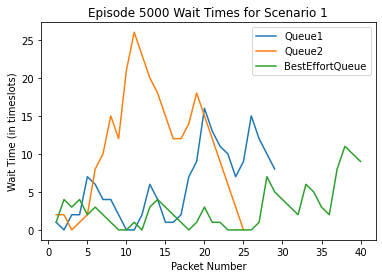

Populated Queues with arrival rates: [0.3, 0.25, 0.4]. Packets per timeslot: 0.95.
Finished 1875 episodes. Randoms chosen: 107 and Q Chosen: 13. Epsilon is: 0.8750666666666804
Finished 3750 episodes. Randoms chosen: 96 and Q Chosen: 23. Epsilon is: 0.7500666666666942
Finished 5625 episodes. Randoms chosen: 72 and Q Chosen: 38. Epsilon is: 0.625066666666708
Finished 7500 episodes. Randoms chosen: 0 and Q Chosen: 105. Epsilon is: 0
Finished all episodes
Average Wait Time in last episode: [5.86, 15.12, 4.38]


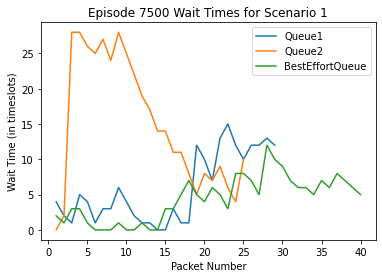

Populated Queues with arrival rates: [0.3, 0.25, 0.4]. Packets per timeslot: 0.95.
Finished 2500 episodes. Randoms chosen: 90 and Q Chosen: 20. Epsilon is: 0.8750500000000138
Finished 5000 episodes. Randoms chosen: 75 and Q Chosen: 35. Epsilon is: 0.7500500000000275
Finished 7500 episodes. Randoms chosen: 63 and Q Chosen: 46. Epsilon is: 0.6250500000000413
Finished 10000 episodes. Randoms chosen: 0 and Q Chosen: 104. Epsilon is: 0
Finished all episodes
Average Wait Time in last episode: [7.03, 5.4, 4.33]


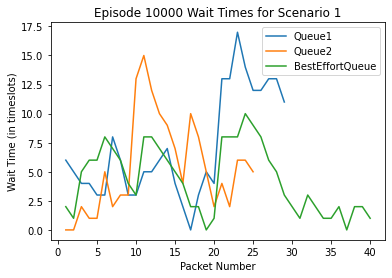

Populated Queues with arrival rates: [0.3, 0.25, 0.4]. Packets per timeslot: 0.95.
Finished 3125 episodes. Randoms chosen: 110 and Q Chosen: 13. Epsilon is: 0.875039999999875
Finished 6250 episodes. Randoms chosen: 90 and Q Chosen: 29. Epsilon is: 0.75003999999975
Finished 9375 episodes. Randoms chosen: 68 and Q Chosen: 40. Epsilon is: 0.625039999999625
Finished 12500 episodes. Randoms chosen: 0 and Q Chosen: 104. Epsilon is: 0
Finished all episodes
Average Wait Time in last episode: [3.93, 12.8, 3.77]


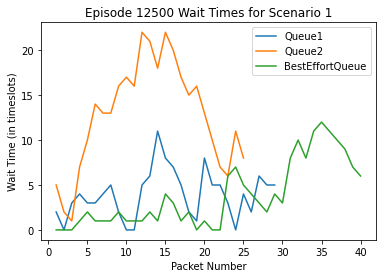

Populated Queues with arrival rates: [0.3, 0.25, 0.4]. Packets per timeslot: 0.95.
Finished 3750 episodes. Randoms chosen: 102 and Q Chosen: 14. Epsilon is: 0.8750333333333471
Finished 7500 episodes. Randoms chosen: 83 and Q Chosen: 30. Epsilon is: 0.7500333333333609
Finished 11250 episodes. Randoms chosen: 68 and Q Chosen: 39. Epsilon is: 0.6250333333333746
Finished 15000 episodes. Randoms chosen: 0 and Q Chosen: 104. Epsilon is: 0
Finished all episodes
Average Wait Time in last episode: [2.83, 3.52, 6.58]


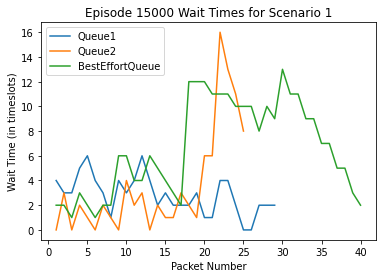

Populated Queues with arrival rates: [0.3, 0.25, 0.4]. Packets per timeslot: 0.95.
Finished 4375 episodes. Randoms chosen: 97 and Q Chosen: 13. Epsilon is: 0.8750285714287933
Finished 8750 episodes. Randoms chosen: 84 and Q Chosen: 24. Epsilon is: 0.7500285714290152
Finished 13125 episodes. Randoms chosen: 66 and Q Chosen: 42. Epsilon is: 0.6250285714292372
Finished 17500 episodes. Randoms chosen: 0 and Q Chosen: 104. Epsilon is: 0
Finished all episodes
Average Wait Time in last episode: [4.0, 3.24, 5.88]


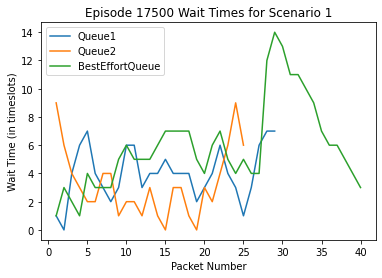

Populated Queues with arrival rates: [0.3, 0.25, 0.4]. Packets per timeslot: 0.95.
Finished 5000 episodes. Randoms chosen: 101 and Q Chosen: 8. Epsilon is: 0.8750249999997363
Finished 10000 episodes. Randoms chosen: 97 and Q Chosen: 20. Epsilon is: 0.7500249999994725
Finished 15000 episodes. Randoms chosen: 72 and Q Chosen: 44. Epsilon is: 0.6250249999992087
Finished 20000 episodes. Randoms chosen: 0 and Q Chosen: 104. Epsilon is: 0
Finished all episodes
Average Wait Time in last episode: [4.38, 2.36, 4.83]


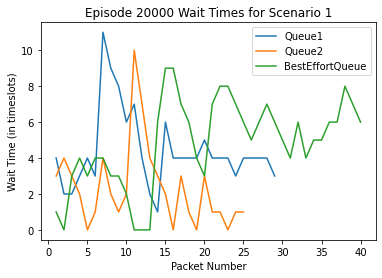

Populated Queues with arrival rates: [0.3, 0.25, 0.4]. Packets per timeslot: 0.95.
Finished 5625 episodes. Randoms chosen: 127 and Q Chosen: 15. Epsilon is: 0.8750222222220279
Finished 11250 episodes. Randoms chosen: 96 and Q Chosen: 30. Epsilon is: 0.7500222222218335
Finished 16875 episodes. Randoms chosen: 64 and Q Chosen: 47. Epsilon is: 0.6250222222216391
Finished 22500 episodes. Randoms chosen: 0 and Q Chosen: 104. Epsilon is: 0
Finished all episodes
Average Wait Time in last episode: [2.72, 2.48, 3.05]


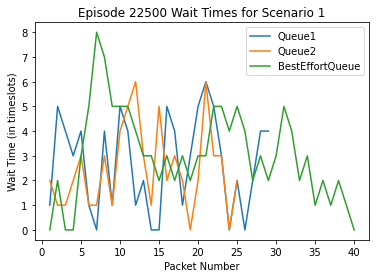

Populated Queues with arrival rates: [0.3, 0.25, 0.4]. Packets per timeslot: 0.95.
Finished 6250 episodes. Randoms chosen: 100 and Q Chosen: 15. Epsilon is: 0.875019999999875
Finished 12500 episodes. Randoms chosen: 83 and Q Chosen: 28. Epsilon is: 0.75001999999975
Finished 18750 episodes. Randoms chosen: 73 and Q Chosen: 43. Epsilon is: 0.625019999999625
Finished 25000 episodes. Randoms chosen: 0 and Q Chosen: 104. Epsilon is: 0
Finished all episodes
Average Wait Time in last episode: [4.03, 2.0, 3.15]


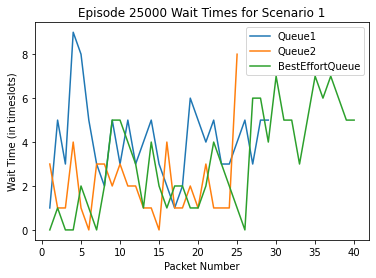

Populated Queues with arrival rates: [0.3, 0.25, 0.4]. Packets per timeslot: 0.95.
Finished 6875 episodes. Randoms chosen: 97 and Q Chosen: 16. Epsilon is: 0.875018181818265
Finished 13750 episodes. Randoms chosen: 74 and Q Chosen: 33. Epsilon is: 0.7500181818183481
Finished 20625 episodes. Randoms chosen: 73 and Q Chosen: 36. Epsilon is: 0.6250181818184313
Finished 27500 episodes. Randoms chosen: 0 and Q Chosen: 104. Epsilon is: 0
Finished all episodes
Average Wait Time in last episode: [3.34, 3.12, 7.25]


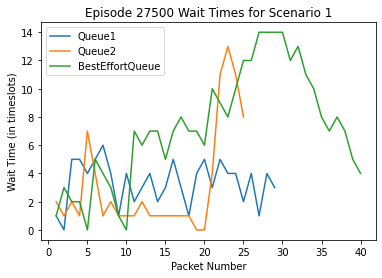

Populated Queues with arrival rates: [0.3, 0.25, 0.4]. Packets per timeslot: 0.95.
Finished 7500 episodes. Randoms chosen: 126 and Q Chosen: 13. Epsilon is: 0.8750166666666804
Finished 15000 episodes. Randoms chosen: 85 and Q Chosen: 29. Epsilon is: 0.7500166666666942
Finished 22500 episodes. Randoms chosen: 60 and Q Chosen: 51. Epsilon is: 0.625016666666708
Finished 30000 episodes. Randoms chosen: 0 and Q Chosen: 103. Epsilon is: 0
Finished all episodes
Average Wait Time in last episode: [3.03, 1.44, 2.23]


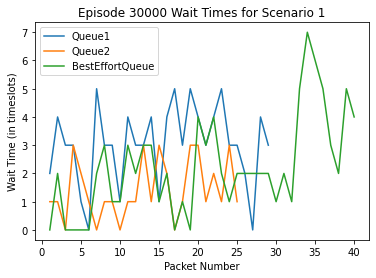

In [8]:
range_of_episodes = np.arange(EPISODES, (EPISODES*6)+1, EPISODES/2) # +1 because the 'stop' is not inclusive.

for current_episode_range in range_of_episodes:
    populated_queues = prepopulate_queues(default_arrival_rates)
    env = QueueSimulator(default_arrival_rates, MEAN_DELAY_REQUIREMENTS, populated_queues)
    q_table = create_q_table()
    result_q_table = q_learning_episode_range(env, q_table, current_episode_range)
    print('Average Wait Time in last episode: {0}'.format(env.calc_average_wait_time()))
    graph_q_learning_wait_times_last_episode(env)

As predicted, the more episodes we gave it, the more situations it was exposed to and able to apply its experience to the final episodes. This took less than 10 minutes to run locally which means if we wanted to, we could try bumping up the numbers more. However for now we can conclude, that having >=30000 episodes to train with will be a good number of episodes to use with training other parameters, since this many episodes will be a good reflection of how effective a parameter's value is.
Another thing to note that is very important is the fluctuation in wait times for each queue in the last few graphs. The lines are very straight and uniform, indicating that the model is choosing the optimal actions from the q-table.


In [6]:
optimal_training_episodes = 30000
optimal_training_episodes_intervals = optimal_training_episodes//5

## Tuning 2.1: Linear Epsilon Decay
Epsilon plays a very large part in the learning process because the agent chooses an action based off a random number against the epsilon. Our formula is 'random < epsilon' to perform the q_table action, but we noticed that epsilon does not reduce much (actually, the epsilon is reset to 1.0 at the start of every episode despite going down by the decay value at the end of the episode), so we should tackle this rate somehow.
One strategy that comes to mind is to make the agent more likely to choose the Q-Table as the episodes go on through a linear decay value.
There is still possibility for a random action even at the latest episodes, which can be detrimental since our Q-Table is probably better than a random action, BUT it still has the potential to find a better result as well.

In [10]:
def q_learning_epsilon_linear(env, q_table, max_decay):
    # Start decaying from ep1, and instead of stopping around halfway, do not stop (to see how effective our q-table becomes as episodes go on)
    epsilon = EPSILON
    epsi_decay_value = (max_decay/optimal_training_episodes)
    
    random_chosen = 0
    q_chosen = 0
    
    for episode in range(1,optimal_training_episodes+1):
        done = False
        state = max_limit_state(env.reset(episode))
        steps = 0
        random_chosen = 0
        q_chosen = 0
        
        # On the last episode, try only using the q-table.
        if episode == optimal_training_episodes:
            epsilon = 0

        # Early episodes almost guarantee a random action. With each episode however, the epsilon will decay, improving the chance of choosing a q_table action
        while not done:
            if np.random.random() < epsilon:
                action = env.action_space.sample()
                random_chosen += 1
            else:
                action = np.argmax(q_table[state])
                q_chosen += 1

            # Get the next state, reward, new done value, and info (not sure what this is)
            # Also, in early episodes the queues can wait for very long times. Put a limit on the wait times in new_state
            new_state, reward, done, info = env.step(action)
            new_state = max_limit_state(new_state)

            # Update QTable and calc reward. Not sure why current_q in example is 'discretState+(action,)'
            new_max_q = np.max(q_table[new_state])
            current_q = q_table[new_state][action]
            q_table[new_state][action] = (1 - LEARNING_RATE)*current_q + LEARNING_RATE*(reward + DISCOUNT*new_max_q)

            state = new_state
            steps += 1
            
        # Print progress every X episodes
        if episode % optimal_training_episodes_intervals == 0 and episode != 0:
            print('Finished {0} episodes. Randoms chosen: {1} and Q Chosen: {2}. Epsilon is: {3}'.format(episode, random_chosen, q_chosen, epsilon))

        epsilon -= epsi_decay_value

    print('Finished all episodes')
    env.close()
    return q_table

Populated Queues with arrival rates: [0.3, 0.25, 0.4]. Packets per timeslot: 0.95.
Finished 6000 episodes. Randoms chosen: 87 and Q Chosen: 21. Epsilon is: 0.8300283333335519
Finished 12000 episodes. Randoms chosen: 63 and Q Chosen: 44. Epsilon is: 0.6600283333337704
Finished 18000 episodes. Randoms chosen: 46 and Q Chosen: 60. Epsilon is: 0.49002833333396945
Finished 24000 episodes. Randoms chosen: 30 and Q Chosen: 77. Epsilon is: 0.32002833333385494
Finished 30000 episodes. Randoms chosen: 0 and Q Chosen: 104. Epsilon is: 0
Finished all episodes
Average Wait Time in last episode: [3.97, 1.28, 2.88]


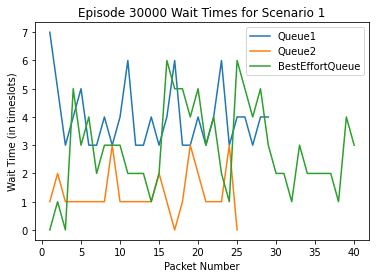

Finished 6000 episodes. Randoms chosen: 103 and Q Chosen: 13. Epsilon is: 0.8500249999996835
Finished 12000 episodes. Randoms chosen: 79 and Q Chosen: 31. Epsilon is: 0.700024999999367
Finished 18000 episodes. Randoms chosen: 63 and Q Chosen: 44. Epsilon is: 0.5500249999990504
Finished 24000 episodes. Randoms chosen: 41 and Q Chosen: 64. Epsilon is: 0.4000249999989559
Finished 30000 episodes. Randoms chosen: 0 and Q Chosen: 104. Epsilon is: 0
Finished all episodes
Average Wait Time in last episode: [3.62, 1.48, 2.62]


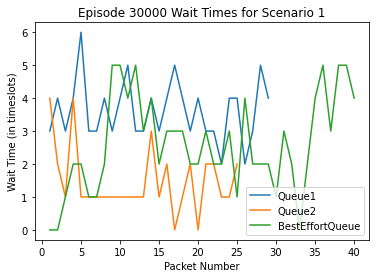

Finished 6000 episodes. Randoms chosen: 109 and Q Chosen: 12. Epsilon is: 0.9000166666666777
Finished 12000 episodes. Randoms chosen: 93 and Q Chosen: 19. Epsilon is: 0.8000166666666887
Finished 18000 episodes. Randoms chosen: 75 and Q Chosen: 32. Epsilon is: 0.7000166666666997
Finished 24000 episodes. Randoms chosen: 76 and Q Chosen: 40. Epsilon is: 0.6000166666667107
Finished 30000 episodes. Randoms chosen: 0 and Q Chosen: 104. Epsilon is: 0
Finished all episodes
Average Wait Time in last episode: [4.1, 2.28, 3.95]


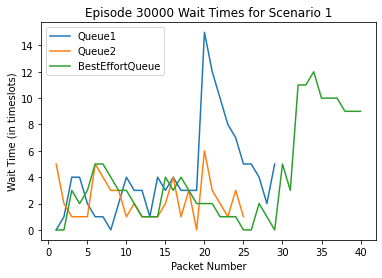

[-1, -1, -1]

In [11]:
populated_queues = prepopulate_queues(default_arrival_rates)
env = QueueSimulator(default_arrival_rates, MEAN_DELAY_REQUIREMENTS, populated_queues)

q_table = create_q_table()
result_q_table = q_learning_epsilon_linear(env, q_table, 0.85)
print('Average Wait Time in last episode: {0}'.format(env.calc_average_wait_time()))
graph_q_learning_wait_times_last_episode(env)
env.reset(1)

q_table = create_q_table()
result_q_table = q_learning_epsilon_linear(env, q_table, 0.75)
print('Average Wait Time in last episode: {0}'.format(env.calc_average_wait_time()))
graph_q_learning_wait_times_last_episode(env)
env.reset(1)

q_table = create_q_table()
result_q_table = q_learning_epsilon_linear(env, q_table, 0.5)
print('Average Wait Time in last episode: {0}'.format(env.calc_average_wait_time()))
graph_q_learning_wait_times_last_episode(env)
env.reset(1)


## Tuning 2.2: Exponential Epsilon Decay
Instead of decaying epsilon linearly per episode, we can try decaying epsilon exponentially per episode interval.

In [11]:
def q_learning_epsilon_exponential(env, q_table, decay_multiplier):
    epsilon = EPSILON
    epsi_decay_value = decay_multiplier
    
    random_chosen = 0
    q_chosen = 0
    
    for episode in range(1,optimal_training_episodes+1):
        done = False
        state = max_limit_state(env.reset(episode))
        steps = 0
        random_chosen = 0
        q_chosen = 0
        
        # On the last episode, try only using the q-table.
        if episode == optimal_training_episodes:
            epsilon = 0

        # Early episodes almost guarantee a random action. With each episode however, the epsilon will decay, improving the chance of choosing a q_table action
        while not done:
            if np.random.random() < epsilon:
                action = env.action_space.sample()
                random_chosen += 1
            else:
                action = np.argmax(q_table[state])
                q_chosen += 1
                
            # Get the next state, reward, new done value, and info (not sure what this is)
            # Also, in early episodes the queues can wait for very long times. Put a limit on the wait times in new_state
            new_state, reward, done, info = env.step(action)
            new_state = max_limit_state(new_state)

            # Update QTable and calc reward. Not sure why current_q in example is 'discretState+(action,)'
            new_max_q = np.max(q_table[new_state])
            current_q = q_table[new_state][action]
            q_table[new_state][action] = (1 - LEARNING_RATE)*current_q + LEARNING_RATE*(reward + DISCOUNT*new_max_q)

            state = new_state
            steps += 1
            
        # Print progress every X episodes
        if episode % optimal_training_episodes_intervals == 0 and episode != 0:
            print('Finished {0} episodes. Randoms chosen: {1} and Q Chosen: {2}. Epsilon is: {3}'.format(episode, random_chosen, q_chosen, epsilon))
            epsilon = epsilon * epsi_decay_value

    print('Finished all episodes')
    env.close()
    return q_table

Pre-populated the Queues with arrival rates: [0.3, 0.25, 0.4]
Finished 6000 episodes. Randoms chosen: 130 and Q Chosen: 0. Epsilon is: 1.0
Finished 12000 episodes. Randoms chosen: 102 and Q Chosen: 17. Epsilon is: 0.9
Finished 18000 episodes. Randoms chosen: 87 and Q Chosen: 29. Epsilon is: 0.81
Finished 24000 episodes. Randoms chosen: 83 and Q Chosen: 28. Epsilon is: 0.7290000000000001
Finished 30000 episodes. Randoms chosen: 0 and Q Chosen: 103. Epsilon is: 0
Finished all episodes
Average Wait Time in last episode: [3.93, 2.24, 15.65]


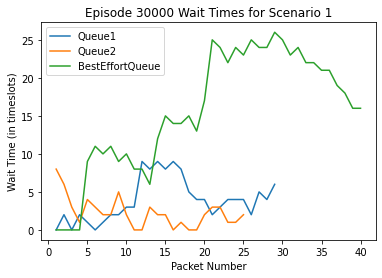

Finished 6000 episodes. Randoms chosen: 120 and Q Chosen: 0. Epsilon is: 1.0
Finished 12000 episodes. Randoms chosen: 74 and Q Chosen: 43. Epsilon is: 0.7
Finished 18000 episodes. Randoms chosen: 61 and Q Chosen: 53. Epsilon is: 0.48999999999999994
Finished 24000 episodes. Randoms chosen: 25 and Q Chosen: 81. Epsilon is: 0.3429999999999999
Finished 30000 episodes. Randoms chosen: 0 and Q Chosen: 104. Epsilon is: 0
Finished all episodes
Average Wait Time in last episode: [3.79, 1.52, 1.75]


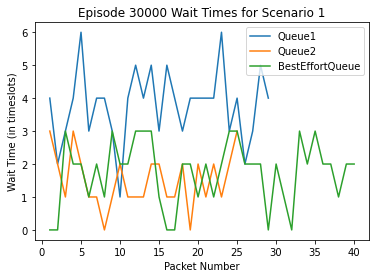

Finished 6000 episodes. Randoms chosen: 129 and Q Chosen: 0. Epsilon is: 1.0
Finished 12000 episodes. Randoms chosen: 55 and Q Chosen: 55. Epsilon is: 0.5
Finished 18000 episodes. Randoms chosen: 22 and Q Chosen: 81. Epsilon is: 0.25
Finished 24000 episodes. Randoms chosen: 8 and Q Chosen: 96. Epsilon is: 0.125
Finished 30000 episodes. Randoms chosen: 0 and Q Chosen: 104. Epsilon is: 0
Finished all episodes
Average Wait Time in last episode: [4.14, 1.84, 1.82]


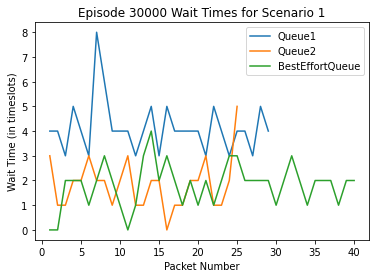

[-1, -1, -1]

In [12]:
populated_queues = prepopulate_queues(default_arrival_rates)
env = QueueSimulator(default_arrival_rates, MEAN_DELAY_REQUIREMENTS, populated_queues)

q_table = create_q_table()
result_q_table = q_learning_epsilon_exponential(env, q_table, 0.9)
print('Average Wait Time in last episode: {0}'.format(env.calc_average_wait_time()))
graph_q_learning_wait_times_last_episode(env)
env.reset(1)

q_table = create_q_table()
result_q_table = q_learning_epsilon_exponential(env, q_table, 0.7)
print('Average Wait Time in last episode: {0}'.format(env.calc_average_wait_time()))
graph_q_learning_wait_times_last_episode(env)
env.reset(1)

q_table = create_q_table()
result_q_table = q_learning_epsilon_exponential(env, q_table, 0.5)
print('Average Wait Time in last episode: {0}'.format(env.calc_average_wait_time()))
graph_q_learning_wait_times_last_episode(env)
env.reset(1)

## Discussion on Epsilon
For Linearly Decaying Epsilon, we tried three 30000 episode runs with max decay values of 0.85, 0.75, and 0.5 (max decay value is the most epsilon can decay by, i.e. by the end epsilon would be equal to 1 - max decay value). It performed the best with 0.85 and 0.75 was close, while a max decay of 0.5 over 30000 episodes still had the model struggling somewhat. This is because for the very large number of episodes, the epsilon decays very slowly, thus taking more exploration and finding many different states. With 0.5 maximum, it decays a bit faster, resulting in choosing exploitation more often even though the Q-Table does not have a large range of situations for the model to handle.

For Exponentially Decaying Epsilon, it performed better with a lower decay multiplier (the value epsilon multiplies to itself every interval of episodes). This is odd at first because as epsilon gets lower there is more exploitation, but as we explained before the model needs to do a lot of exploration to fill the Q-Table before using exploitation for better performance. However, since the epsilon only decays AFTER A SET OF EPISODES, for that first set of episodes the model has an epsilon of 1.0 meaning it is entirely random and hence only exploring.
It is important to consider that with these very good results, the model could be 'overfitted', as in it only performs well when given the arrival rates of \[0.3, 0.25, 0.4]\. So, we should take the optimal parameters we've found thus far and apply it to different arrival rates to see how the model performs against varying arrival rates.

In [7]:
optimal_training_epsilon_linear_decay = 0.75

## Tuning (Kinda) 3.1: Pseudo Random Arrival Rates
If we were to train our model extensively over many different arrival rates, it would be exposed to many different types of situations and have more experience to draw from when considering the best action to take. Choosing a set of arrival rates is difficult as they could be anything, so for now in training we'll use pseudo-random arrival rates.

The arrival rates will be pseudo random because if we were to get large values e.g. \[0.8, 0.7, 0.7], this is about 2.2 packets per timeslot, which will cause some queues to be backlogged and fall behind in wait time. The default \[0.3, 0.25, 0.4] equates to about 0.95 packets per timeslot which is appropriate since we are only allowed to transmit 1 packet maximum per timeslot. Thus, our arrival rates will be some step change of the default.

In [12]:
def q_learning_random_arrival_rates(number_of_loops):
    different_arrival_rates = []
    for i in range(number_of_loops):
        # Loop for values until they meet the condition.
        random_rates = copy.deepcopy(default_arrival_rates)
        if np.random.uniform(0, 1) > 0.5:
            random_rates[0] += np.random.uniform(0, 0.1)
        else:
            random_rates[0] -= np.random.uniform(0, 0.1)
        random_rates[1] += np.random.uniform(0, 0.1)
        if np.random.uniform(0, 1) > 0.5:
            random_rates[2] += np.random.uniform(0, 0.1)
        else:
            random_rates[2] -= np.random.uniform(0, 0.1)

        random_rates = [round(i, 2) for i in random_rates]
        different_arrival_rates.append(random_rates)
    
    for i, random_arrival_rates in enumerate(different_arrival_rates):
        populated_queues = prepopulate_queues(random_arrival_rates)
        env = QueueSimulator(random_arrival_rates, MEAN_DELAY_REQUIREMENTS, populated_queues)

        q_table = create_q_table()
        result_q_table = q_learning_epsilon_linear(env, q_table, 0.75)
        print('Average Wait Time in last episode: {0}'.format(env.calc_average_wait_time()))
        graph_q_learning_wait_times_last_episode(env)

Populated Queues with arrival rates: [0.37, 0.31, 0.36]. Packets per timeslot: 1.04.
Finished 6000 episodes. Randoms chosen: 100 and Q Chosen: 21. Epsilon is: 0.8500249999996835
Finished 12000 episodes. Randoms chosen: 91 and Q Chosen: 27. Epsilon is: 0.700024999999367
Finished 18000 episodes. Randoms chosen: 64 and Q Chosen: 47. Epsilon is: 0.5500249999990504
Finished 24000 episodes. Randoms chosen: 37 and Q Chosen: 75. Epsilon is: 0.4000249999989559
Finished 30000 episodes. Randoms chosen: 0 and Q Chosen: 110. Epsilon is: 0
Finished all episodes
Average Wait Time in last episode: [7.08, 3.71, 5.72]


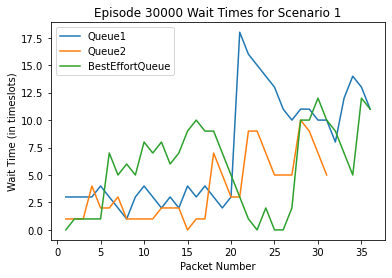

Populated Queues with arrival rates: [0.37, 0.35, 0.45]. Packets per timeslot: 1.17.
Finished 6000 episodes. Randoms chosen: 139 and Q Chosen: 13. Epsilon is: 0.8500249999996835
Finished 12000 episodes. Randoms chosen: 95 and Q Chosen: 34. Epsilon is: 0.700024999999367
Finished 18000 episodes. Randoms chosen: 80 and Q Chosen: 64. Epsilon is: 0.5500249999990504
Finished 24000 episodes. Randoms chosen: 66 and Q Chosen: 65. Epsilon is: 0.4000249999989559
Finished 30000 episodes. Randoms chosen: 0 and Q Chosen: 121. Epsilon is: 0
Finished all episodes
Average Wait Time in last episode: [10.78, 10.32, 17.64]


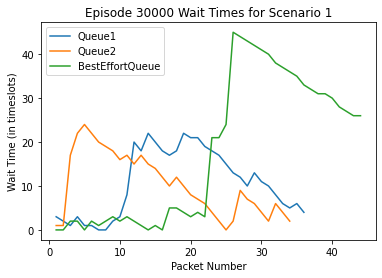

Populated Queues with arrival rates: [0.37, 0.33, 0.41]. Packets per timeslot: 1.1099999999999999.
Finished 6000 episodes. Randoms chosen: 94 and Q Chosen: 25. Epsilon is: 0.8500249999996835
Finished 12000 episodes. Randoms chosen: 82 and Q Chosen: 43. Epsilon is: 0.700024999999367
Finished 18000 episodes. Randoms chosen: 81 and Q Chosen: 39. Epsilon is: 0.5500249999990504
Finished 24000 episodes. Randoms chosen: 46 and Q Chosen: 77. Epsilon is: 0.4000249999989559
Finished 30000 episodes. Randoms chosen: 0 and Q Chosen: 114. Epsilon is: 0
Finished all episodes
Average Wait Time in last episode: [3.78, 2.45, 17.95]


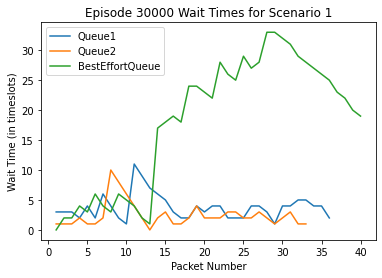

Populated Queues with arrival rates: [0.38, 0.25, 0.32]. Packets per timeslot: 0.95.
Finished 6000 episodes. Randoms chosen: 102 and Q Chosen: 20. Epsilon is: 0.8500249999996835
Finished 12000 episodes. Randoms chosen: 81 and Q Chosen: 28. Epsilon is: 0.700024999999367
Finished 18000 episodes. Randoms chosen: 69 and Q Chosen: 42. Epsilon is: 0.5500249999990504
Finished 24000 episodes. Randoms chosen: 45 and Q Chosen: 62. Epsilon is: 0.4000249999989559
Finished 30000 episodes. Randoms chosen: 0 and Q Chosen: 104. Epsilon is: 0
Finished all episodes
Average Wait Time in last episode: [2.76, 1.28, 2.19]


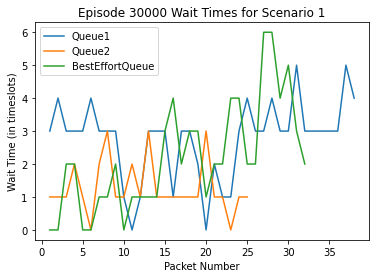

Populated Queues with arrival rates: [0.23, 0.26, 0.37]. Packets per timeslot: 0.86.
Finished 6000 episodes. Randoms chosen: 91 and Q Chosen: 16. Epsilon is: 0.8500249999996835
Finished 12000 episodes. Randoms chosen: 74 and Q Chosen: 31. Epsilon is: 0.700024999999367
Finished 18000 episodes. Randoms chosen: 47 and Q Chosen: 56. Epsilon is: 0.5500249999990504
Finished 24000 episodes. Randoms chosen: 38 and Q Chosen: 64. Epsilon is: 0.4000249999989559
Finished 30000 episodes. Randoms chosen: 0 and Q Chosen: 102. Epsilon is: 0
Finished all episodes
Average Wait Time in last episode: [1.82, 1.08, 2.86]


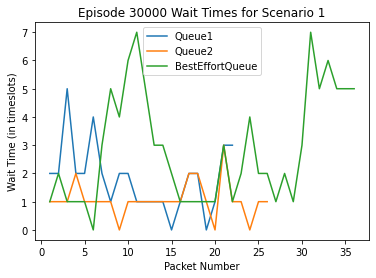

Populated Queues with arrival rates: [0.35, 0.3, 0.33]. Packets per timeslot: 0.98.
Finished 6000 episodes. Randoms chosen: 104 and Q Chosen: 20. Epsilon is: 0.8500249999996835
Finished 12000 episodes. Randoms chosen: 71 and Q Chosen: 36. Epsilon is: 0.700024999999367
Finished 18000 episodes. Randoms chosen: 61 and Q Chosen: 49. Epsilon is: 0.5500249999990504
Finished 24000 episodes. Randoms chosen: 45 and Q Chosen: 63. Epsilon is: 0.4000249999989559
Finished 30000 episodes. Randoms chosen: 0 and Q Chosen: 102. Epsilon is: 0
Finished all episodes
Average Wait Time in last episode: [2.71, 2.55, 4.94]


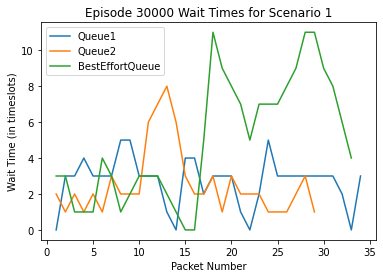

Populated Queues with arrival rates: [0.22, 0.33, 0.4]. Packets per timeslot: 0.9500000000000001.
Finished 6000 episodes. Randoms chosen: 89 and Q Chosen: 20. Epsilon is: 0.8500249999996835
Finished 12000 episodes. Randoms chosen: 76 and Q Chosen: 32. Epsilon is: 0.700024999999367
Finished 18000 episodes. Randoms chosen: 72 and Q Chosen: 44. Epsilon is: 0.5500249999990504
Finished 24000 episodes. Randoms chosen: 52 and Q Chosen: 60. Epsilon is: 0.4000249999989559
Finished 30000 episodes. Randoms chosen: 0 and Q Chosen: 103. Epsilon is: 0
Finished all episodes
Average Wait Time in last episode: [2.24, 1.61, 5.72]


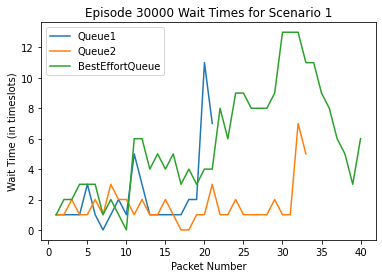

Populated Queues with arrival rates: [0.38, 0.27, 0.4]. Packets per timeslot: 1.05.
Finished 6000 episodes. Randoms chosen: 132 and Q Chosen: 23. Epsilon is: 0.8500249999996835
Finished 12000 episodes. Randoms chosen: 81 and Q Chosen: 34. Epsilon is: 0.700024999999367
Finished 18000 episodes. Randoms chosen: 62 and Q Chosen: 55. Epsilon is: 0.5500249999990504
Finished 24000 episodes. Randoms chosen: 53 and Q Chosen: 66. Epsilon is: 0.4000249999989559
Finished 30000 episodes. Randoms chosen: 0 and Q Chosen: 113. Epsilon is: 0
Finished all episodes
Average Wait Time in last episode: [4.97, 2.26, 9.3]


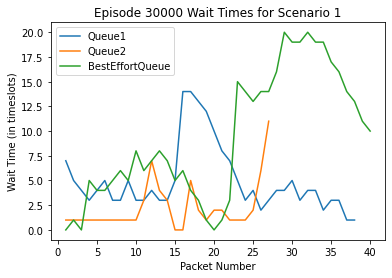

Populated Queues with arrival rates: [0.22, 0.34, 0.47]. Packets per timeslot: 1.03.
Finished 6000 episodes. Randoms chosen: 96 and Q Chosen: 23. Epsilon is: 0.8500249999996835
Finished 12000 episodes. Randoms chosen: 102 and Q Chosen: 36. Epsilon is: 0.700024999999367
Finished 18000 episodes. Randoms chosen: 60 and Q Chosen: 57. Epsilon is: 0.5500249999990504
Finished 24000 episodes. Randoms chosen: 44 and Q Chosen: 67. Epsilon is: 0.4000249999989559
Finished 30000 episodes. Randoms chosen: 0 and Q Chosen: 107. Epsilon is: 0
Finished all episodes
Average Wait Time in last episode: [1.57, 1.97, 8.67]


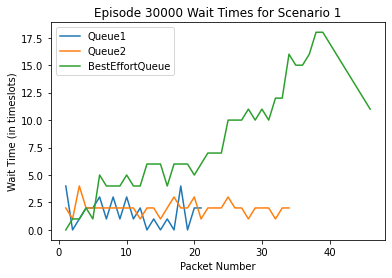

Populated Queues with arrival rates: [0.31, 0.3, 0.45]. Packets per timeslot: 1.06.
Finished 6000 episodes. Randoms chosen: 115 and Q Chosen: 19. Epsilon is: 0.8500249999996835
Finished 12000 episodes. Randoms chosen: 92 and Q Chosen: 29. Epsilon is: 0.700024999999367
Finished 18000 episodes. Randoms chosen: 59 and Q Chosen: 59. Epsilon is: 0.5500249999990504
Finished 24000 episodes. Randoms chosen: 45 and Q Chosen: 72. Epsilon is: 0.4000249999989559
Finished 30000 episodes. Randoms chosen: 0 and Q Chosen: 113. Epsilon is: 0
Finished all episodes
Average Wait Time in last episode: [3.35, 2.07, 11.2]


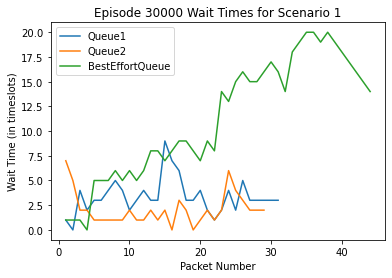

1): array([1216.72533034, 1604.9988457 , 1573.84886452]),
 (-1, 12, 0): array([568.23653299, 464.81663271, 648.0481223 ]),
 (-1, 12, 1): array([181.18516157,  77.68365844, 242.80884884]),
 (-1, 12, 2): array([520.91561227, 405.60015324, 572.91239199]),
 (-1, 12, 3): array([112.54179011,  91.60145183, 120.78515958]),
 (-1, 12, 4): array([351.62319312, 360.0701484 , 421.28579955]),
 (-1, 12, 5): array([198.88194593, 206.29414148, 203.88074012]),
 (-1, 12, 6): array([270.20064872, 446.88326072, 274.64192157]),
 (-1, 12, 7): array([357.12514492, 382.88884386, 310.59530821]),
 (-1, 12, 8): array([620.96030472, 686.86245939, 653.214449  ]),
 (-1, 12, 9): array([460.54783853, 544.49097689, 453.54520753]),
 (-1, 12, 10): array([717.82424049, 799.38339874, 831.75819474]),
 (-1, 12, 11): array([873.50192484, 945.923038  , 938.56173975]),
 (-1, 12, 12): array([654.44986717, 664.11367431, 709.73940802]),
 (-1, 12, 13): array([669.74162617, 760.45520492, 699.99750675]),
 (-1, 12, 14): array([ 951.8

In [34]:
q_learning_random_arrival_rates(10)

# Discussion on Random Arrival Rates
Learning across different arrival rates shows that the model still does well to keep under the mean delay requirement for PQ1 and PQ2 but struggles somewhat for best-effort queue. The Q-Table was reset between using different arrival rates however, so we will have to see how keeping the Q-Table between runs will perform for different arrival rates at the end.

# Final Model for Scenario 1
We'll train a model for 35000 episodes (the optimal was 30000 so we can try an extra 5000 for safety), while incorporating linear epsilon decay at a maximum decay of 0.85 to 0.75 and using the default arrival rates.

After training it with these conditions, we can train it further with random arrival rates to take its current experience and apply it to more difficult situations. Then after this, we will run it once against many random arrival rates to test its effectiveness.

In [19]:
def q_learning_final_scenario_1(env, q_table, number_of_episodes, max_decay):
    epsilon = EPSILON
    epsi_decay_value = (max_decay/number_of_episodes)
    test_intervals = number_of_episodes//4
    
    random_chosen = 0
    q_chosen = 0
    
    for episode in range(1,number_of_episodes+1):
        done = False
        state = max_limit_state(env.reset(episode))
        steps = 0
        random_chosen = 0
        q_chosen = 0

        while not done:
            if np.random.random() < epsilon:
                action = env.action_space.sample()
                random_chosen += 1
            else:
                action = np.argmax(q_table[state])
                q_chosen += 1
                
            # Get the next state, reward, new done value, and info (not sure what this is)
            # Also, in early episodes the queues can wait for very long times. Put a limit on the wait times in new_state
            new_state, reward, done, info = env.step(action)
            new_state = max_limit_state(new_state)

            # Update QTable and calc reward. Not sure why current_q in example is 'discretState+(action,)'
            new_max_q = np.max(q_table[new_state])
            current_q = q_table[new_state][action]
            q_table[new_state][action] = (1 - LEARNING_RATE)*current_q + LEARNING_RATE*(reward + DISCOUNT*new_max_q)

            state = new_state
            steps += 1
            
        # Print progress every X episodes
        if episode % test_intervals == 0 and episode != 0:
            print('Finished {0} episodes. Randoms chosen: {1} and Q Chosen: {2}. Epsilon is: {3}'.format(episode, random_chosen, q_chosen, epsilon))

        epsilon -= epsi_decay_value

    print('Finished all episodes')
    env.close()
    return q_table

In [20]:
def train_against_random_arrival_rates(q_table, number_of_rates, number_of_episodes):
    different_arrival_rates = []
    for i in range(number_of_rates):
        # Loop for values until they meet the condition.
        random_rates = copy.deepcopy(default_arrival_rates)
        if np.random.uniform(0, 1) > 0.5:
            random_rates[0] += np.random.uniform(0, 0.1)
        else:
            random_rates[0] -= np.random.uniform(0, 0.1)
        random_rates[1] += np.random.uniform(0, 0.1)
        if np.random.uniform(0, 1) > 0.5:
            random_rates[2] += np.random.uniform(0, 0.1)
        else:
            random_rates[2] -= np.random.uniform(0, 0.1)

        random_rates = [round(i, 2) for i in random_rates]
        different_arrival_rates.append(random_rates)
    
    for i, random_arrival_rates in enumerate(different_arrival_rates):
        populated_queues = prepopulate_queues(random_arrival_rates)
        env = QueueSimulator(random_arrival_rates, MEAN_DELAY_REQUIREMENTS, populated_queues)
        q_table = q_learning_final_scenario_1(env, q_table, number_of_episodes, 0.75)
        print('Average Wait Time in last episode: {0}'.format(env.calc_average_wait_time()))
        # graph_model_vs_arrival_rates(env)
    return q_table

In [21]:
# Difference between this and tran_against_... is that this method only runs once against a set of arrival_rates.
def test_against_random_arrival_rates(q_table, number_of_loops):
    different_arrival_rates = []
    for i in range(number_of_loops):
        # Loop for values until they meet the condition.
        random_rates = copy.deepcopy(default_arrival_rates)
        if np.random.uniform(0, 1) > 0.5:
            random_rates[0] += np.random.uniform(0, 0.1)
        else:
            random_rates[0] -= np.random.uniform(0, 0.1)
        random_rates[1] += np.random.uniform(0, 0.1)
        if np.random.uniform(0, 1) > 0.5:
            random_rates[2] += np.random.uniform(0, 0.1)
        else:
            random_rates[2] -= np.random.uniform(0, 0.1)

        random_rates = [round(i, 2) for i in random_rates]
        different_arrival_rates.append(random_rates)
    
    # Run ONE episode for each arrival rate and see how our model performs.
    for i, random_arrival_rates in enumerate(different_arrival_rates):
        populated_queues = prepopulate_queues(random_arrival_rates)
        env = QueueSimulator(random_arrival_rates, MEAN_DELAY_REQUIREMENTS, populated_queues)

        done = False
        state = max_limit_state(env.reset(0))
        steps = 0
        while not done:
            action = np.argmax(q_table[state])
                
            new_state, reward, done, info = env.step(action)
            new_state = max_limit_state(new_state)

            new_max_q = np.max(q_table[new_state])
            current_q = q_table[new_state][action]
            q_table[new_state][action] = (1 - LEARNING_RATE)*current_q + LEARNING_RATE*(reward + DISCOUNT*new_max_q)

            state = max_limit_state(new_state)
            steps += 1
        env.update_last_episode_stats(1)
        print('Average Wait Time in last episode: {0}'.format(env.calc_average_wait_time()))
        graph_model_vs_arrival_rates(env)

Populated Queues with arrival rates: [0.3, 0.25, 0.4]. Packets per timeslot: 0.95.
Finished 8750 episodes. Randoms chosen: 104 and Q Chosen: 14. Epsilon is: 0.8125214285710329
Finished 17500 episodes. Randoms chosen: 76 and Q Chosen: 36. Epsilon is: 0.6250214285706372
Finished 26250 episodes. Randoms chosen: 50 and Q Chosen: 59. Epsilon is: 0.43752142857040344
Finished 35000 episodes. Randoms chosen: 23 and Q Chosen: 82. Epsilon is: 0.2500214285704935
Finished all episodes
Average Wait Time in last episode: [3.72, 1.76, 2.8]

Training on random arrival rates.
Populated Queues with arrival rates: [0.27, 0.27, 0.37]. Packets per timeslot: 0.91.
Finished 2500 episodes. Randoms chosen: 91 and Q Chosen: 15. Epsilon is: 0.8125749999998819
Finished 5000 episodes. Randoms chosen: 58 and Q Chosen: 45. Epsilon is: 0.6250749999997638
Finished 7500 episodes. Randoms chosen: 31 and Q Chosen: 73. Epsilon is: 0.4375749999996919
Finished 10000 episodes. Randoms chosen: 24 and Q Chosen: 79. Epsilon is:

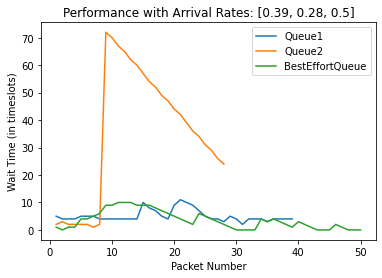

Populated Queues with arrival rates: [0.33, 0.27, 0.49]. Packets per timeslot: 1.09.
Average Wait Time in last episode: [5.06, 11.44, 4.83]


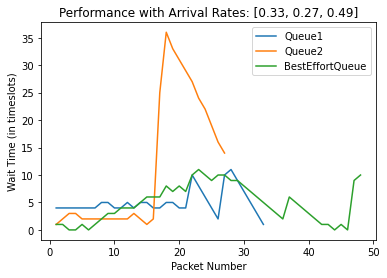

Populated Queues with arrival rates: [0.34, 0.26, 0.32]. Packets per timeslot: 0.92.
Average Wait Time in last episode: [4.47, 2.38, 1.47]


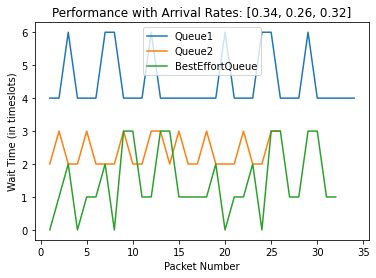

Populated Queues with arrival rates: [0.37, 0.32, 0.38]. Packets per timeslot: 1.07.
Average Wait Time in last episode: [5.03, 7.59, 4.74]


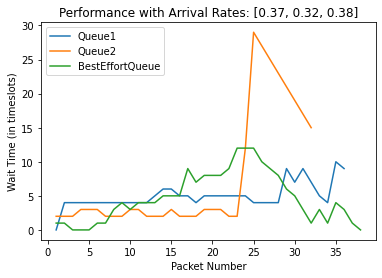

Populated Queues with arrival rates: [0.25, 0.3, 0.4]. Packets per timeslot: 0.95.
Average Wait Time in last episode: [4.16, 2.14, 0.97]


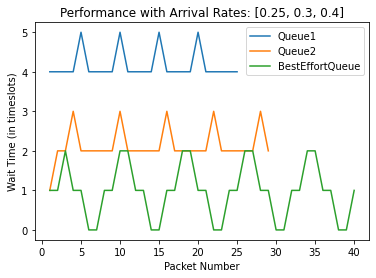

In [22]:
populated_queues = prepopulate_queues(default_arrival_rates)
env = QueueSimulator(default_arrival_rates, MEAN_DELAY_REQUIREMENTS, populated_queues)
final_q_table_scen1 = create_q_table()

# First do the training with the default arrival rates to introduce the model into the environment
final_q_table_scen1 = q_learning_final_scenario_1(env, final_q_table_scen1, 35000, 0.75)
print('Average Wait Time in last episode: {0}'.format(env.calc_average_wait_time()))
print('\nTraining on random arrival rates.')
# Now, using the same q-table, train against random arrival rates, for X episodes per set of arrival rates.
final_q_table_scen1 = train_against_random_arrival_rates(final_q_table_scen1, 10, 10000)

print('\n---Final Testing against random arrival rates.---')
test_against_random_arrival_rates(final_q_table_scen1, 5)

# Scenario 2
For scenario 2, we won't be exploring tuning the parameters since the more important point of tuning the parameters was to identify optimal values for those parameters and why they were optimal. In scenario 2 the model should now also include an extra column in the state Q-Table. Instead of just having the total wait times for each queue, the model should also know what queue it is currently sitting in, since it will be penalised or rewarded for switching/not switching queues (not really a reward, rather it should learn that switching queues a lot is bad).

In [6]:
# Same as above create_q_table except has an extra loop. Extra loop has values: -1 (no previous queue), 0, 1, 2.
def create_q_table_scenario_2():
    q_table = {}
    for q1 in range (-1, MAX_WAIT_STATE+1):
        for q2 in range (-1, MAX_WAIT_STATE+1):
            for q3 in range (-1, MAX_WAIT_STATE+1):
                for current_queue in range (-1, 3):
                    q_table[q1, q2, q3, current_queue] = np.zeros(3)
    return q_table

In [7]:
def q_learning_initial_scenario_2(env, q_table):
    for episode in range(1,EPISODES+1):
        done = False
        state = max_limit_state(env.reset(episode))
        steps = 0
        epsilon = EPSILON

        # Either do action from QTable or random action
        while not done:
            if np.random.random() < 1 - epsilon:
                action = np.argmax(q_table[state])
            else:
                action = env.action_space.sample()
                
            # Get the next state, reward, new done value, and info (not sure what this is)
            # Also, in early episodes the queues can wait for very long times. Put a limit on the wait times in new_state
            new_state, reward, done, info = env.step(action)
            new_state = max_limit_state(new_state)

            # Update QTable and calc reward. Not sure why current_q in example is 'discretState+(action,)'
            new_max_q = np.max(q_table[new_state])
            current_q = q_table[new_state][action]
            q_table[new_state][action] = (1 - LEARNING_RATE)*current_q + LEARNING_RATE*(reward + DISCOUNT*new_max_q)

            state = new_state
            steps += 1

        # Finished done loop, update epsilon
        if END_EPSILON_DECAYING >= episode and episode >= START_EPSILON_DECAYING:
            epsilon -= epsilon_decay_value
            
        # Print progress every X episodes
        if episode % TEST_INTERVAL == 0 and episode != 0:
            print('Finished {0} episodes'.format(episode))

    print('Finished all episodes')
    env.close()
    return q_table

In [ ]:
populated_queues = prepopulate_queues(default_arrival_rates)
env = QueueSimulatorScenario2(default_arrival_rates, MEAN_DELAY_REQUIREMENTS, populated_queues)
q_table = create_q_table_scenario_2()
result_q_table = q_learning_initial_scenario_2(env, q_table)
print('Total number of queue switches in the last episode: {0}'.format(env.total_queue_switches))
graph_q_learning_wait_times(env)

# Initial Model Results - Scenario 2
As expected, model performs poorly because it switches queues constantly and is thus increasing the timeslots by a large amount. Let's try using the optimal episodes and optimal linear epsilon decay.

# Using optimal parameters

In [17]:
def q_learning_optimal_scenario_2(env, q_table):
    # Start decaying from ep1, and instead of stopping around halfway, do not stop (to see how effective our q-table becomes as episodes go on)
    epsilon = EPSILON
    epsi_decay_value = (optimal_training_epsilon_linear_decay/optimal_training_episodes)
    
    random_chosen = 0
    q_chosen = 0
    t = optimal_training_episodes
    
    for episode in range(1,t+1):
        done = False
        state = max_limit_state(env.reset(episode))
        steps = 0
        random_chosen = 0
        q_chosen = 0

        while not done:
            if np.random.random() < epsilon:
                action = env.action_space.sample()
                random_chosen += 1
            else:
                action = np.argmax(q_table[state])
                q_chosen += 1

            # Get the next state, reward, new done value, and info (not sure what this is)
            # Also, in early episodes the queues can wait for very long times. Put a limit on the wait times in new_state
            new_state, reward, done, info = env.step(action)
            new_state = max_limit_state(new_state)

            # Update QTable and calc reward. Not sure why current_q in example is 'discretState+(action,)'
            new_max_q = np.max(q_table[new_state])
            current_q = q_table[new_state][action]
            q_table[new_state][action] = (1 - LEARNING_RATE)*current_q + LEARNING_RATE*(reward + DISCOUNT*new_max_q)

            state = new_state
            steps += 1
            
        # Print progress every X episodes
        if episode % optimal_training_episodes_intervals == 0 and episode != 0:
            print('Finished {0} episodes. Randoms chosen: {1} and Q Chosen: {2}. Epsilon is: {3}'.format(episode, random_chosen, q_chosen, epsilon))

        epsilon -= epsi_decay_value

    print('Finished all episodes')
    env.close()
    return q_table

Populated Queues with arrival rates: [0.3, 0.25, 0.4]. Packets per timeslot: 0.95.
Finished 8000 episodes. Randoms chosen: 104 and Q Chosen: 14. Epsilon is: 0.8500187500003495
Finished 16000 episodes. Randoms chosen: 89 and Q Chosen: 33. Epsilon is: 0.7000187500006991
Finished 24000 episodes. Randoms chosen: 75 and Q Chosen: 57. Epsilon is: 0.5500187500010487
Finished 32000 episodes. Randoms chosen: 51 and Q Chosen: 84. Epsilon is: 0.40001875000110226
Finished 40000 episodes. Randoms chosen: 26 and Q Chosen: 94. Epsilon is: 0.25001875000100776
Finished all episodes
Total number of queue switches in the last episode: 66
Average Wait Time in last episode: [10.0, 6.8, 67.62]


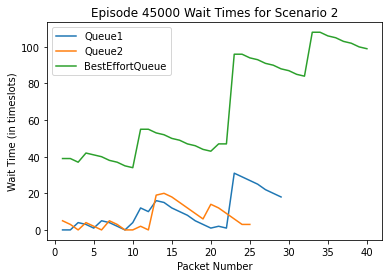

In [18]:
optimal_training_episodes = 40000
optimal_training_episodes_intervals = optimal_training_episodes//5
optimal_training_epsilon_linear_decay = 0.75

populated_queues = prepopulate_queues(default_arrival_rates)
env = QueueSimulatorScenario2(default_arrival_rates, MEAN_DELAY_REQUIREMENTS, populated_queues)
final_q_table_scen2 = create_q_table_scenario_2()
final_q_table_scen2 = q_learning_optimal_scenario_2(env, final_q_table_scen2)
print('Total number of queue switches in the last episode: {0}'.format(env.total_queue_switches))
print('Average Wait Time in last episode: {0}'.format(env.calc_average_wait_time()))
graph_q_learning_wait_times_last_episode(env)

# First-In-First-Out
Implementation is straight forward, transmit packets who arrive first. QueueSimulator can be used here but with logic to decide 'action' instead of epsilon/randomness

Populated Queues with arrival rates: [0.3, 0.25, 0.4]. Packets per timeslot: 0.95.
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
[0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1]


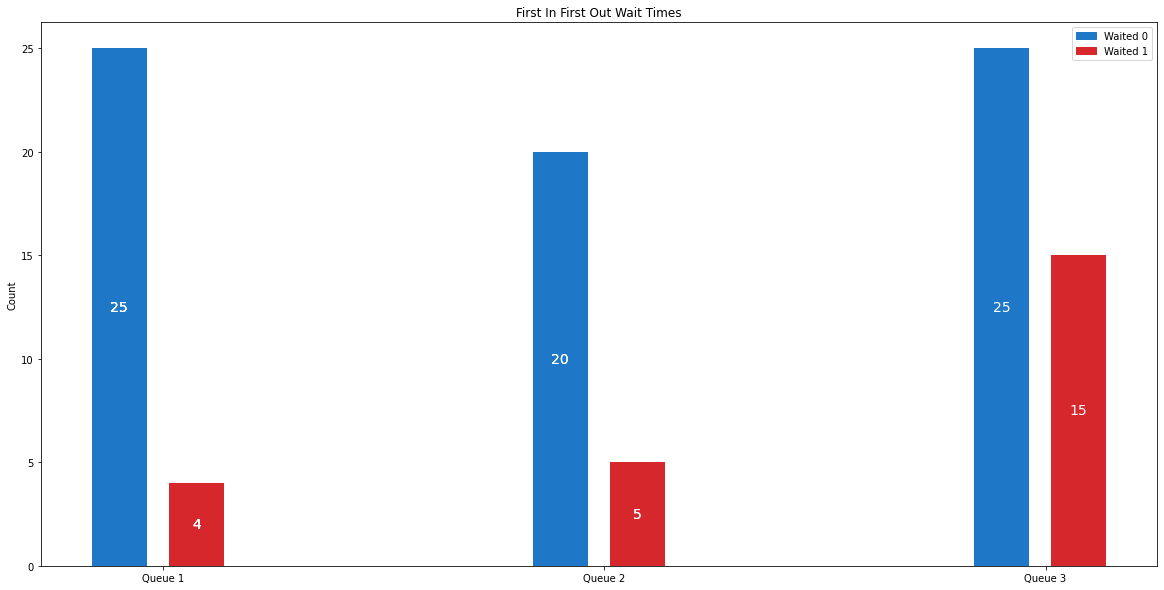

In [23]:
def first_in_first_out(env):
    env.reset(1)
    done = False
    
    while not done:
        # Our action is based on lowest value and if theres no packets left in a queue then its a '0' which is lowest possible. Hence, Set initial values to maximum
        current_state = [np.inf, np.inf, np.inf]
        for i, queue in enumerate(env.queues):
            # Check that first element of queue has actually arrived
            if len(queue) > 0 and env.current_timeslot >= queue[0]:
                current_state[i] = queue[0]
        
        # Action should be the packet that arrived first (i.e. lowest value)
        action = current_state.index(min(current_state))
        _, _, done, _ = env.step(action)
    
    return env.packets_total_wait_times

populated_queues = prepopulate_queues(default_arrival_rates)
env = QueueSimulator(default_arrival_rates, MEAN_DELAY_REQUIREMENTS, populated_queues)
fifo_wait_times = first_in_first_out(env)

# Since the wait times were either 0 or 1, can just plot a hist or bar chart with x labels 0 or 1
fig, ax = plt.subplots(figsize=(20, 10))
bar_width = 0.25
for i, queue_wait_times in enumerate(fifo_wait_times):
    print(queue_wait_times)
    waited_0 = sum(1 for wait_time in queue_wait_times if wait_time == 0)
    waited_1 = sum(1 for wait_time in queue_wait_times if wait_time == 1)

    ax.bar(i*2, waited_0, bar_width, label='Waited 0', color='#1F77C7')
    ax.bar((i*2)+bar_width+0.1, waited_1, bar_width, label='Waited 1', color='#D6272C')
    ax.set_title('First In First Out Wait Times')
    ax.set_xticks((0.2, 2.2, 4.2))
    ax.set_xticklabels(("Queue 1", "Queue 2", "Queue 3"))
    ax.set_ylabel('Count')
    ax.legend(handles=[mpatches.Patch(color='#1F77C7', label='Waited 0'), mpatches.Patch(color='#D6272C', label='Waited 1')])
    
    for rect in ax.patches:
        h = rect.get_height()
        w = rect.get_width()
        x = rect.get_x()
        y = rect.get_y()
        label_text = f'{h}'
        label_x = x + w/2
        label_y = y + h/2
        
        if h != 0:
            ax.text(label_x, label_y, label_text, ha='center', va='center', fontsize=14, color='white')


# Earliest Deadline First
Bit more complicated than FIFO, because we need to consider difference in waiting and mean_delay_requirement, but also what to do with the best effort queue which has no mean delay requirement.
If the wait time for the best effort queue is less than the difference of (waiting and mean delay requirement) for the other two queues, prioritise best effort queue

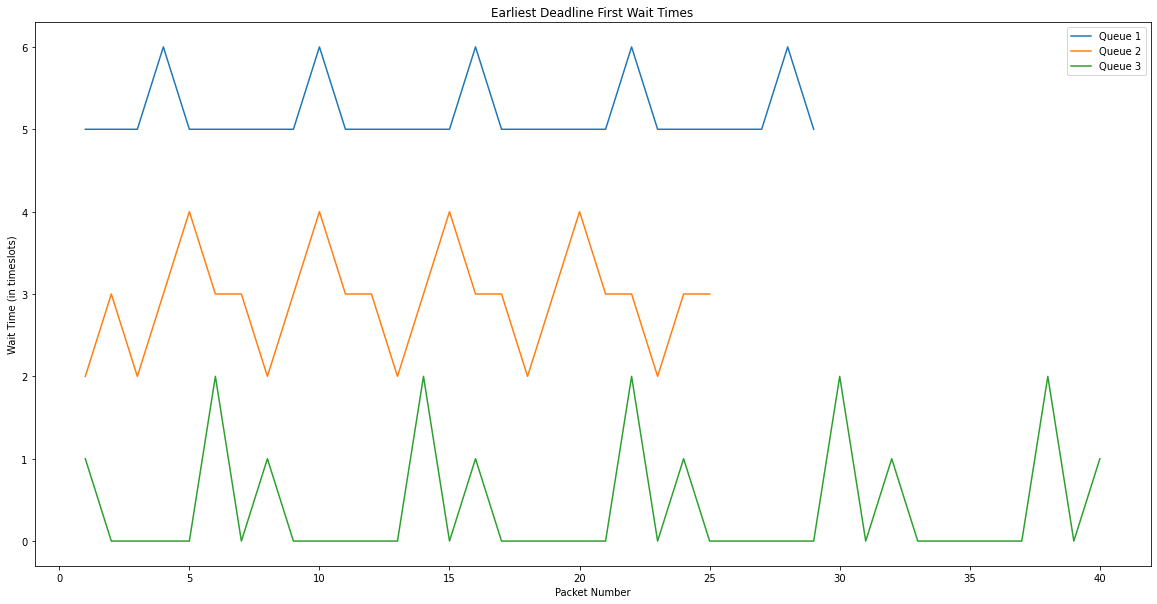

In [24]:
def earliest_deadline_first(env):
    env.reset(1)
    done = False
    
    while not done:
        # Use np.inf as an indicator that a packet hasn't arrived. So, you consider to transmit a queue only if there exists a packet in that queue. Will always default (through else statements) to queue 2.
        current_state = [np.inf, np.inf, np.inf]
        for i, queue in enumerate(env.queues):
            if len(queue) > 0 and env.current_timeslot >= queue[0]:
                current_state[i] = env.current_timeslot - queue[0]
                
        q1_diff = MEAN_DELAY_REQUIREMENTS[0] - current_state[0]
        q2_diff = MEAN_DELAY_REQUIREMENTS[1] - current_state[1]
        q3_wait = current_state[2]
            
        if (q3_wait < q1_diff and q3_wait < q2_diff and q3_wait != np.inf):
            action = 2
        else:
            if q1_diff < q2_diff and q1_diff != -np.inf:
                action = 0
            else:
                action = 1

        current_state, reward, done, info = env.step(action)
    return env.packets_total_wait_times

edf_wait_times = earliest_deadline_first(env)

fig, ax = plt.subplots(figsize=(20, 10))
bar_width = 0.25
for i, queue_wait_times in enumerate(edf_wait_times):
    data_y = queue_wait_times
    data_x = [*range(1, len(data_y)+1, 1)]

    ax.set_title('Earliest Deadline First Wait Times')
    ax.set_xlabel('Packet Number')
    ax.set_ylabel('Wait Time (in timeslots)')
    ax.plot(data_x, data_y, label='Queue {0}'.format(i+1))
ax.legend()
fig.show()

# Sequential Priority Policy
With SPP, I believe that when the specifications say 'select a packet from the _highest priority queue_', the highest priority queue is whatever queue we believe it to be (i.e. its up to us to decide which queue is the most important). Best Effort Queue is always chosen to minimise the mean delay, so I think that the choice is either Priority Queue 1 or Priority Queue 2. As PQ2 has a lower mean delay requirement, it must output quicker and hence should be prioritised higher vs PQ1 which is given a longer time before it is needed to transmit.

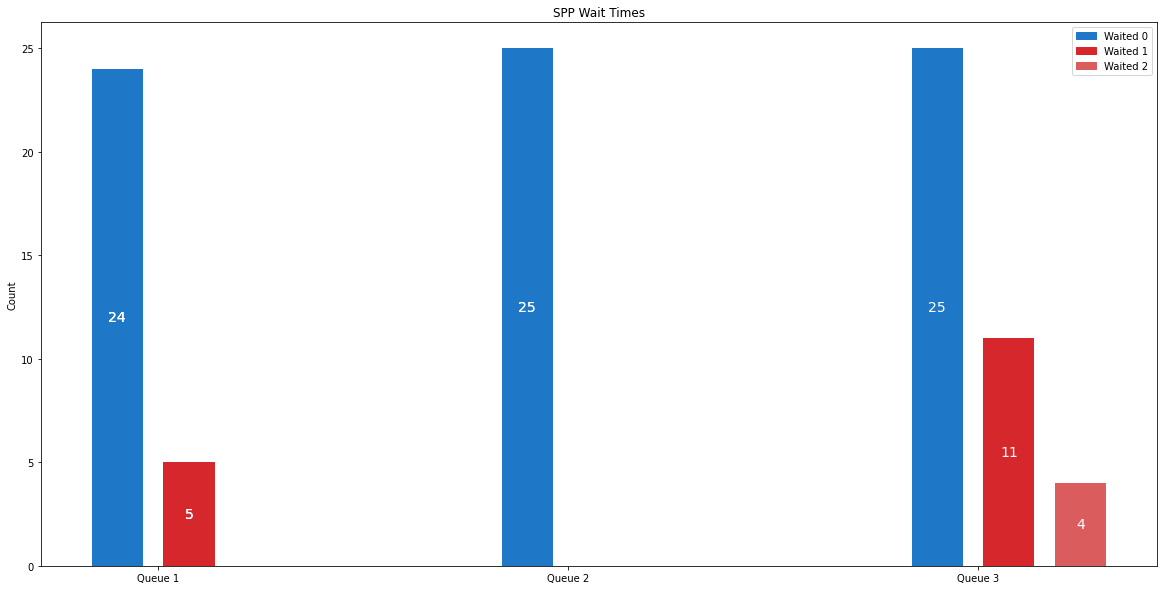

In [25]:
def sequential_priority_policy(env):
    current_state = env.reset(1)
    done = False
    
    while not done:
        # Use np.inf as an indicator that a packet hasn't arrived. So, you consider to transmit a queue only if there exists a packet in that queue. Will always default (through else statements) to queue 2.
        current_state = [np.inf, np.inf, np.inf]
        for i, queue in enumerate(env.queues):
            if len(queue) > 0 and env.current_timeslot >= queue[0]:
                current_state[i] = queue[0]
                
        action = 1
        if current_state[action] == np.inf:
            action = 0
            if current_state[action] == np.inf:
                action = 2
        
        new_state, reward, done, info = env.step(action)
    return env.packets_total_wait_times

spp_wait_times = sequential_priority_policy(env)
    
# Since the wait times were either 0 or 1, can just plot a hist or bar chart with x labels 0 or 1
fig, ax = plt.subplots(figsize=(20, 10))
bar_width = 0.25
for i, queue_wait_times in enumerate(spp_wait_times):
    waited_0 = sum(1 for wait_time in queue_wait_times if wait_time == 0)
    waited_1 = sum(1 for wait_time in queue_wait_times if wait_time == 1)
    waited_2 = sum(1 for wait_time in queue_wait_times if wait_time == 2)

    ax.bar(i*2, waited_0, bar_width, label='Waited 0', color='#1F77C7')
    ax.bar((i*2)+bar_width+0.1, waited_1, bar_width, label='Waited 1', color='#D6272C')
    ax.bar((i*2)+(bar_width*2)+0.2, waited_2, bar_width, label='Waited 2', color='#DB5C5C')
    ax.set_title('SPP Wait Times')
    ax.set_xticks((0.2, 2.2, 4.2))
    ax.set_xticklabels(("Queue 1", "Queue 2", "Queue 3"))
    ax.set_ylabel('Count')
    ax.legend(handles=[mpatches.Patch(color='#1F77C7', label='Waited 0'), mpatches.Patch(color='#D6272C', label='Waited 1'), mpatches.Patch(color='#DB5C5C', label='Waited 2')])
    
    for rect in ax.patches:
        h = rect.get_height()
        w = rect.get_width()
        x = rect.get_x()
        y = rect.get_y()
        label_text = f'{h}'
        label_x = x + w/2
        label_y = y + h/2
        
        if h != 0:
            ax.text(label_x, label_y, label_text, ha='center', va='center', fontsize=14, color='white')
    

# Extra Scheduling Algorithms
There are more scheduling algorithms that are popular and also with some, are easy to implement. Such algorithms are ones like Shortest-Job Next (not sure how that fits into this context however) and Round Robin. Round Robin is relatively straightforward to implement so we will choose this as an extra scheduling algorithm to compare with.

## Extra - Round Robin
Start the action at 0, then increment with each step. We only want 3 values of action (0, 1, 2) so we can just mod the value of action every increment. *Note*: There is something to consider when the queue chosen is empty and there are other queues ready to transmit, however this is not reflective of Round Robin in my opinion. Hence, even if the queue is empty for a given action, still perform the step.

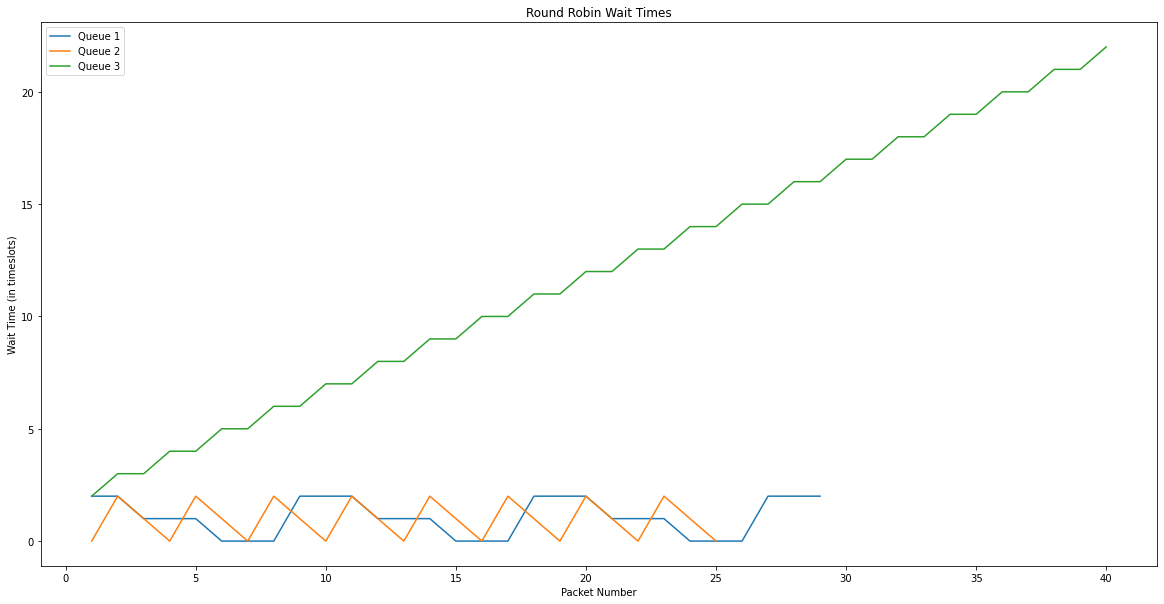

In [26]:
def round_robin(env):
    env.reset(1)
    done = False
    
    while not done:
        action = env.current_timeslot % 3
        new_state, reward, done, info = env.step(action)
    return env.packets_total_wait_times

rr_wait_times = round_robin(env)

fig, ax = plt.subplots(figsize=(20, 10))
bar_width = 0.25
for i, queue_wait_times in enumerate(rr_wait_times):
    data_y = queue_wait_times
    data_x = [*range(1, len(data_y)+1, 1)]

    ax.set_title('Round Robin Wait Times')
    ax.set_xlabel('Packet Number')
    ax.set_ylabel('Wait Time (in timeslots)')
    ax.plot(data_x, data_y, label='Queue {0}'.format(i+1))
ax.legend()
fig.show()


# Comparing Scenario 1 Final Model vs Schedulers - Graphs


Populated Queues with arrival rates: [0.3, 0.25, 0.4]. Packets per timeslot: 0.95.
Average Wait Time in last episode: [4.45, 2.16, 1.12]


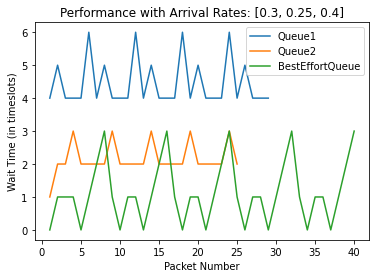

In [30]:
# Run ONE episode for default arrival rate to get results and graph
populated_queues = prepopulate_queues(default_arrival_rates)
env = QueueSimulator(default_arrival_rates, MEAN_DELAY_REQUIREMENTS, populated_queues)

done = False
state = max_limit_state(env.reset(0))
steps = 0
while not done:
    action = np.argmax(final_q_table_scen1[state])
        
    new_state, reward, done, info = env.step(action)
    new_state = max_limit_state(new_state)

    new_max_q = np.max(final_q_table_scen1[new_state])
    current_q = final_q_table_scen1[new_state][action]
    final_q_table_scen1[new_state][action] = (1 - LEARNING_RATE)*current_q + LEARNING_RATE*(reward + DISCOUNT*new_max_q)

    state = max_limit_state(new_state)
    steps += 1
env.update_last_episode_stats(1)
print('Average Wait Time in last episode: {0}'.format(env.calc_average_wait_time()))
graph_model_vs_arrival_rates(env)

[4.45, 2.16, 1.12]
[0.14, 0.2, 0.38]
[5.17, 2.92, 0.4]
[0.17, 0.0, 0.47]
[1.07, 0.96, 12.0]


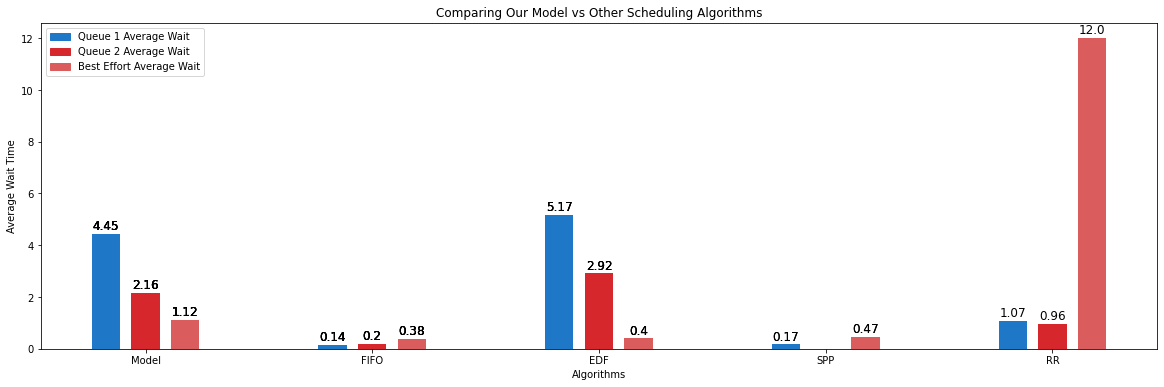

In [55]:
all_wait_times_scen1 = [env.calc_average_wait_time(), fifo_wait_times, edf_wait_times, spp_wait_times, rr_wait_times]

# Since the wait times were either 0 or 1, can just plot a hist or bar chart with x labels 0 or 1
fig, ax = plt.subplots(figsize=(20, 6))
bar_width = 0.25
for i, algorithm in enumerate(all_wait_times_scen1):
    if i == 0:
        average_wait_per_queue = algorithm
        print(average_wait_per_queue)
    else:
        average_wait_per_queue = []
        for j, queue_wait_time in enumerate(algorithm):
            average_wait_per_queue.append(round(sum(queue_wait_time)/len(queue_wait_time),2))
        print(average_wait_per_queue)

    q1_y = average_wait_per_queue[0]
    q2_y = average_wait_per_queue[1]
    q3_y = average_wait_per_queue[2]

    ax.bar(i*2, q1_y, bar_width, label='Queue 1 Average Wait', color='#1F77C7')
    ax.bar((i*2)+bar_width+0.1, q2_y, bar_width, label='Queue 2 Average Wait', color='#D6272C')
    ax.bar((i*2)+(bar_width*2)+0.2, q3_y, bar_width, label='Best Effort Average Wait', color='#DB5C5C')
    ax.set_title('Comparing Our Model vs Other Scheduling Algorithms')
    ax.set_xticks((0.35, 2.35, 4.35, 6.35, 8.35))
    ax.set_xticklabels(("Model", "FIFO", "EDF", "SPP", "RR"))
    ax.set_xlabel('Algorithms')
    ax.set_ylabel('Average Wait Time')
    ax.legend(handles=[mpatches.Patch(color='#1F77C7', label='Queue 1 Average Wait'), mpatches.Patch(color='#D6272C', label='Queue 2 Average Wait'), mpatches.Patch(color='#DB5C5C', label='Best Effort Average Wait')])
    
    for rect in ax.patches:
        h = rect.get_height()
        w = rect.get_width()
        x = rect.get_x()
        y = rect.get_y()
        label_text = f'{h}'
        label_x = x + w/2
        label_y = y + h + 0.3
        
        if h != 0:
            ax.text(label_x, label_y, label_text, ha='center', va='center', fontsize=12, color='black')

# Comparing Scenario 2 Final Model vs Schedulers - Graphs

In [56]:
# Run ONE episode for default arrival rate to get results and graph
populated_queues = prepopulate_queues(default_arrival_rates)
env = QueueSimulatorScenario2(default_arrival_rates, MEAN_DELAY_REQUIREMENTS, populated_queues)

done = False
state = max_limit_state(env.reset(0))
steps = 0
while not done:
    action = np.argmax(final_q_table_scen2[state])
        
    new_state, reward, done, info = env.step(action)
    new_state = max_limit_state(new_state)

    new_max_q = np.max(final_q_table_scen2[new_state])
    current_q = final_q_table_scen2[new_state][action]
    final_q_table_scen2[new_state][action] = (1 - LEARNING_RATE)*current_q + LEARNING_RATE*(reward + DISCOUNT*new_max_q)

    state = max_limit_state(new_state)
    steps += 1
env.update_last_episode_stats(1)
print('Average Wait Time in last episode: {0}'.format(env.calc_average_wait_time()))
graph_model_vs_arrival_rates(env)

Populated Queues with arrival rates: [0.3, 0.25, 0.4]. Packets per timeslot: 0.95.


NameError: name 'final_q_table_scen2' is not defined

In [ ]:
populated_queues = prepopulate_queues(default_arrival_rates)
env = QueueSimulatorScenario2(default_arrival_rates, MEAN_DELAY_REQUIREMENTS, populated_queues)
final_q_table_scen2 = create_q_table_scenario_2()
final_q_table_scen2 = q_learning_optimal_scenario_2(env, final_q_table_scen2)
print('Total number of queue switches in the last episode: {0}'.format(env.total_queue_switches))
print('Average Wait Time in last episode: {0}'.format(env.calc_average_wait_time()))
graph_q_learning_wait_times_last_episode(env)

all_wait_times = [env.calc_average_wait_time(), fifo_wait_times, edf_wait_times, spp_wait_times, rr_wait_times]

# Since the wait times were either 0 or 1, can just plot a hist or bar chart with x labels 0 or 1
fig, ax = plt.subplots(figsize=(20, 6))
bar_width = 0.25
for i, algorithm in enumerate(all_wait_times):
    if i == 0:
        average_wait_per_queue = algorithm
        print(average_wait_per_queue)
    else:
        average_wait_per_queue = []
        for j, queue_wait_time in enumerate(algorithm):
            average_wait_per_queue.append(round(sum(queue_wait_time)/len(queue_wait_time),2))
        print(average_wait_per_queue)

    q1_y = average_wait_per_queue[0]
    q2_y = average_wait_per_queue[1]
    q3_y = average_wait_per_queue[2]

    ax.bar(i*2, q1_y, bar_width, label='Queue 1 Average Wait', color='#1F77C7')
    ax.bar((i*2)+bar_width+0.1, q2_y, bar_width, label='Queue 2 Average Wait', color='#D6272C')
    ax.bar((i*2)+(bar_width*2)+0.2, q3_y, bar_width, label='Best Effort Average Wait', color='#DB5C5C')
    ax.set_title('Comparing Our Model vs Other Scheduling Algorithms')
    ax.set_xticks((0.35, 2.35, 4.35, 6.35, 8.35))
    ax.set_xticklabels(("Model", "FIFO", "EDF", "SPP", "RR"))
    ax.set_xlabel('Algorithms')
    ax.set_ylabel('Average Wait Time')
    ax.legend(handles=[mpatches.Patch(color='#1F77C7', label='Queue 1 Average Wait'), mpatches.Patch(color='#D6272C', label='Queue 2 Average Wait'), mpatches.Patch(color='#DB5C5C', label='Best Effort Average Wait')])
    
    for rect in ax.patches:
        h = rect.get_height()
        w = rect.get_width()
        x = rect.get_x()
        y = rect.get_y()
        label_text = f'{h}'
        label_x = x + w/2
        label_y = y + h + 0.3
        
        if h != 0:
            ax.text(label_x, label_y, label_text, ha='center', va='center', fontsize=12, color='black')